# Exercise 1

In [1]:
### preliminaries

import numpy as np
from numpy import random as rnd
from scipy.interpolate import UnivariateSpline
from scipy import integrate
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from code.plot_utils import plot_pretty
plot_pretty()

# for reading the data
import numpy as np

from code.setup import data_home_dir
from matplotlib import pyplot as plt
%matplotlib inline
from code.plot_utils import plot_pretty

plot_pretty()

### The uncertainties in log10-space

Since $\log_{10} (z_i \pm \sigma_{z,i}) = \log_{10} z_i + \log_{10} [1 \pm (\sigma_{z,i}/z_i)] \approx \log_{10} z_i \pm [1/\ln (10)] \; (\sigma_{z,i}/z_i)$, as uncertainties in $\log_{10}$-space we will use 
$$\sigma_{\log_{10} z , i} = \frac{1}{ln (10)} \left( \frac{\sigma_{z, i}}{z_i} \right)$$
as the uncertainty. In the above, $z$ can be either $x$ or $y$.

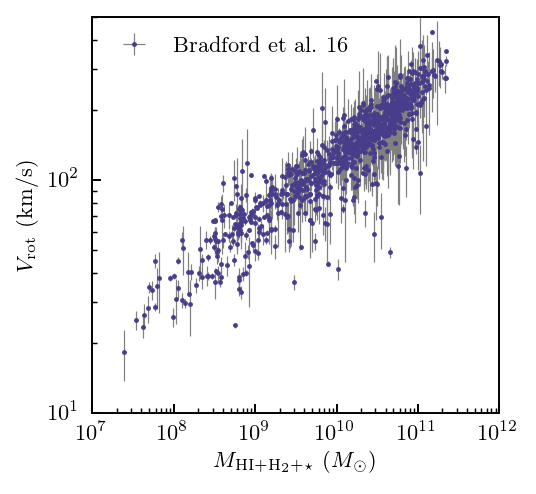

In [2]:
import pyfits

# read the data
data_dir = '/home/georgez/ownCloud/Courses/Computational Astrophysics/a330f17/data/bradford16_fig1.fits'

bf1 = pyfits.open(data_dir)[1].data
# if you want to see what's in the fits table, uncomment
#bf1h = pyfits.open(data_dir)[1].header
#print(bf1h)

# log10 of the baryon mass
mbbar = bf1['MBARYON']
# error of the baryon mass
embar = bf1['MBARYON_ERR']
# width of the 21 cm line = proxy for Vrot in km/s
w20b = bf1['VW20I']
# error of W20b
ew20b = bf1['VW20I_ERR']
#mbs = np.log10(mbs) + 9.0  # stellar mass is in 10^9 Msun in the file -> convert to Msun

"""
Prepare the data for the analysis: Create the data and inverse data arrays
"""
# data array - x = Mass, y = Velocity
data = np.array([10**mbbar, w20b, embar, ew20b])

# data array - x = Velocity, y = Mass
data_inv = np.array([w20b, 10**mbbar, ew20b, embar])
#----------------------------------------------------------------------------

plt.figure(figsize=(3.,3.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_{\rm HI+H_2+\star}\ {(M_\odot)}$')
plt.errorbar(data[0], data[1], xerr=data[2], yerr=data[3], fmt='o', ms=1, elinewidth=0.5, ecolor='gray', \
             c='darkslateblue', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

### Model


Lets assume that the Tully-Fisgher relation is of the form $V_{\rm rot} = C M_b^m$, where $C$ and $m$ are constants; $m$ is dimensionless, but $C$ is not and its dimensions are $[C] = [V]/[M^m]$. So, if we take the logarithm of it, we get, in dimensionless terms,

\begin{equation}
    \log \tilde{V}_{\rm rot} = m \log \tilde{M}_b + \log \left( \frac{C M_0^m}{V_0} \right) \equiv m \log \tilde{M}_b + c \; ,
\end{equation}

where, now, $m$ is the slope of the line in $\log - \log$ space and $c = \log(C M_0^m/V_0)$ the intercept. These two parameters, together with our parameter for the intrinsic scatter, $s$, form the parameter vector $\boldsymbol{\theta} = (m, c, s)$. 

### Likelihood

If we consdifer that there are $N$ points in our data, then the likelihood function can be written as 

\begin{equation}
    \mathcal{L} = \prod \limits_{i=1}^{N} \mathcal{L}_i(\mathcal{D}|\mathcal{M}, \boldsymbol{\theta}) \; ; \; \; \mathcal{L}_i(\mathcal{D}|\mathcal{M}, \boldsymbol{\theta}) = \sqrt{\frac{f(m)}{2\pi \sigma_{\rm tot, i}^2}} \exp \left[ - \frac{(y_i - m x_i - c)^2}{2 \sigma_{\rm tot, i}^2} \right] \; \; ,
\end{equation}
where $f(m) = 1$ and $\sigma_{\rm tot, i}^2 = \sigma_{y,i}^2 + m^2 \sigma_{x,i}^2 + s^2$ for the asymmetric case, while $f(m) = 1 + m^2$ and $\sigma_{\rm tot, i}^2 = \sigma_{y,i}^2 + m^2 \sigma_{x,i}^2 + s_\perp^2 (1+m^2)$ for the symmetric case. $\sigma_{x,i}^2$ and $\sigma_{y,i}^2$ are the uncertainties in the measurements, $s$ is the intrinsic scatter, and $s_\perp$ represents its projection onto the line perpendicular to the fitting line.

### Posterior

Using the Likelihood function, $\mathcal{L}(\mathcal{D}|\mathcal{M}, \boldsymbol{\theta})$, and our prior, $p(\boldsymbol{\theta} | \mathcal{I})$, where $\mathcal{I}$ denotes all of our prior information and knowledge about the model, given the data, the posterior is
\begin{equation}
    \pi (\boldsymbol{\theta} | \mathcal{D}, \mathcal{M}, \mathcal{I}) = \frac{1}{Z} \mathcal{L}(\mathcal{D}|\mathcal{M}, \boldsymbol{\theta}) p(\boldsymbol{\theta} | \mathcal{I}) \; ,
\end{equation}
where $Z \equiv p(\mathcal{D}, \mathcal{I})$ is the evidence and will be treated as a normalization constant.


Then, the logarithm of the posterior will be
$$\ln \pi = \sum \limits_{i=1}^{N} \left( \ln \mathcal{L}_i + \ln p_i \right) = \frac{1}{2} \sum \limits_{i=1}^{N} \left[ \ln \left( \frac{f(m)}{2 \pi \sigma_{\rm tot , i}^2} \right) - \frac{(y_i - mx_i - c)^2}{\sigma_{\rm tot, i}^2} + 2 \ln p_i \right] \; .$$

### Evidence

To calculate the evidence we need to integrate $\mathcal{L} p$ over all the parameter space, $d \boldsymbol{\theta}$, 

$$ Z = \int \mathcal{L} p d \boldsymbol{\theta} \; , $$
assuming that the posterior is normalized to unity.

### Required setup and definitions

In [3]:
def model_lin(theta, x):
    """ 
    Linear fit model
    
    Input:
    ------
    m   - the slope
    c   - the intercept
    eps - intrinsic scatter
    
    Output:
    -------
    The result of the linear model
    """
    m, c, s = theta
    # x = log10(M or V)
    return m * x + c

In [4]:
def plot_mcmc(data_1p, data_2p, data_all, nbins=200, font_size=10, \
              top=0.92, bottom=-0.45, left=0.10, right=0.85, hspace=0.35, wspace=0.35 ):
    """ Plot parameters """
    nbins=nbins; font_size = font_size
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : font_size}
    #--------------------------------------------
    """The plots"""
    from matplotlib.colors import LogNorm
    plt.figure(1)

    # 1 data point
    #-------------

    # m vs c
    sbplt1 = plt.subplot(321)
    plt.hist2d(data_1p[:,0], data_1p[:,1], bins=nbins, norm=LogNorm())
    plt.xlabel(r'm', fontsize=font_size)
    plt.ylabel(r'c', fontsize=font_size)
    sbplt1.set_title('1 data point', color='k', rotation='horizontal',x=0.5,y=1.05)
    sbplt1.xaxis.set_label_position("top")

    # m vs s
    sbplt2 = plt.subplot(322)
    plt.hist2d(data_1p[:,0], data_1p[:,2], bins=nbins, norm=LogNorm())
    plt.xlabel(r'm', fontsize=font_size) 
    plt.ylabel(r's', fontsize=font_size)
    sbplt2.set_title('m=%.3f, c=%.1e, s=$\pm$%.1e'%( np.mean(data_1p[:,0]), np.mean(data_1p[:,1]),\
                            np.mean(data_1p[:,2][data_1p[:,2] > 0]) ), color='k', rotation='horizontal',x=0.5,y=1.05)
    sbplt2.yaxis.set_label_position("right")
    sbplt2.xaxis.set_label_position("top")

    # 2 data points
    #--------------

    # m vs c
    sbplt3 = plt.subplot(323)
    plt.hist2d(data_2p[:,0], data_2p[:,1], bins=nbins, norm=LogNorm())
    #plt.xlabel(r'm', fontsize=font_size)
    plt.ylabel(r'c', fontsize=font_size)
    sbplt3.set_title('2 data points', color='k', rotation='horizontal',x=0.5,y=1.05)
    #sbplt3.yaxis.set_label_position("right")

    # m vs s
    sbplt4 = plt.subplot(324)
    plt.hist2d(data_2p[:,0], data_2p[:,2], bins=nbins, norm=LogNorm())
    #plt.xlabel(r'm', fontsize=font_size) 
    plt.ylabel(r's', fontsize=font_size)
    sbplt4.set_title('m=%.3f, c=%.1e, s=$\pm$%.1e'%( np.mean(data_2p[:,0]),\
                            np.mean(data_2p[:,1]),\
                            np.mean(data_2p[:,2][data_2p[:,2] > 0]) ), color='k', rotation='horizontal',x=0.5,y=1.05)
    sbplt4.yaxis.set_label_position("right")

    # All data points
    #----------------

    # m vs c
    sbplt5 = plt.subplot(325)
    plt.hist2d(data_all[:,0], data_all[:,1], bins=nbins, norm=LogNorm())
    plt.xlabel(r'm', fontsize=font_size); plt.ylabel(r'c', fontsize=font_size)
    sbplt5.set_title('All data points', color='k', rotation='horizontal',x=0.5,y=1.05)
    #sbplt5.yaxis.set_label_position("right")

    # m vs s
    sbplt6 = plt.subplot(326)
    plt.hist2d(data_all[:,0], data_all[:,2], bins=nbins, norm=LogNorm())
    plt.xlabel(r'm', fontsize=font_size); plt.ylabel(r's', fontsize=font_size)
    sbplt6.set_title('m=%.3f, c=%.1e, s=$\pm$%.1e'%( np.mean(data_all[:,0]), np.mean(data_all[:,1]),\
                            np.mean(data_all[:,2][data_all[:,2] > 0]) ),\
                             color='k', rotation='horizontal',x=0.5,y=1.05)
    sbplt6.yaxis.set_label_position("right")

    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=hspace, wspace=wspace)

    plt.rc('font', **font)

    plt.show()
    return

def theta_calc(trace):
    """Returns the theta vector given the mcmc trace"""
    m, c, s = np.mean(trace[:,0]), np.mean(trace[:,1]), np.mean(trace[:,2][trace[:,2] > 0])
    return np.array([m,c,s])

def plot_linear_fit(data_1p, data_2p, data_all, title, inv_label=False,\
                    xlabel=r'$M_{\rm HI+H_2+\star}\ {(M_\odot)}$', ylabel=r'$V_{\rm rot}\ \mathrm{(km/s)}$',\
                    data=data, model=model_lin):
    """Plot of data points and linear fitting"""
    # data
    x, y, sigma_x, sigma_y = data

    # linear fit parameters
    #----------------------
    # 1 point
    theta_1p = theta_calc(data_1p)
    # 2 points
    theta_2p = theta_calc(data_2p)
    # all point
    theta_all = theta_calc(data_all)

    # the plot
    #---------
    xmin, xmax = 1.e7, 1.e12
    ymin, ymax = 10., 500.

    plt.figure(figsize=(3.,3.))
    plt.xscale('log'); plt.yscale('log')
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

    if inv_label: 
        plt.xlabel(ylabel); plt.ylabel(xlabel)
    else:
        plt.xlabel(xlabel); plt.ylabel(ylabel)

    # linear fit model
    #-----------------
    xfit = np.linspace(xmin,xmax)
    # 1 point
    plt.plot(xfit, 10**model(theta_1p, np.log10(xfit)), \
             c='k', ls = '-.', linewidth=1., label=r'1 point')
    # 2 points
    plt.plot(xfit, 10**model(theta_2p, np.log10(xfit)), \
             c='crimson', ls='--', linewidth=1., label=r'2 points')
    # all points
    plt.plot(xfit, 10**model(theta_all, np.log10(xfit)), \
             c='m', ls='-', linewidth=1., label=r'All points')

    # data
    #-----
    plt.errorbar(data[0], data[1], xerr=data[2], yerr=data[3],\
                 fmt='o', ms=1, elinewidth=0.5, ecolor='gray', \
                 c='darkslateblue', label=r'Data', zorder=1)

    plt.legend(frameon=False,loc='upper left', fontsize=9)
    plt.title(title, color='k', rotation='horizontal',x=0.5,y=1.0)
    plt.show()
    return

def conf_level(data, confidence, theta, Np):
    """Find confidence level for data"""
    if confidence < 50.:
        x1 = np.percentile(data, confidence)         # point at x-th percentile
        x2 = np.percentile(data, (100.-confidence)/2.) # point at (1-x)/2-th percentile
    else:
        x2 = np.percentile(data, confidence)         # point at x-th percentile
        x1 = np.percentile(data, (100.-confidence)/2.) # point at (1-x)/2-th percentile
    
    print('%.2f per cent confidence interval for %s using %s point(s) = [%.5f , %.5f]'\
          %(confidence, theta, Np, x1, x2))
    return 

def marg_posterior(data, xlabel, ylabel, title, nbins=40, confidence=0.95, color='darkslateblue'):
    """Plot of marginalized posterior distributions"""
    fig = plt.figure(figsize=(3,3))
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.hist(data, bins=nbins, normed=1.0, color=color, alpha=0.9)
    plt.show()
    return

In [5]:
import emcee
import time

def compute_mcmc(log_posterior, data=data, degree=2,\
                   nwalkers=50, nburn=1000, nsteps=2000):
    """
    MCMC algorithm to explore parameter space
    
    Inputs:
    -------
    degree        - int; degree + 1 is the dimension of theta
    data          - the data we use
    log_posterior - log of the posterior
    nwalkers      - int; number of walkers
    nburn         - int; burn-in
    nsteps        - int; number of steps for walkers
    
    Output:
    -------
    trace         - chain from walkers
    """
    t1 = time.time()
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    t2 = time.time()
    print("Done Sampling in %.3f s"%(t2-t1))
    return trace

# Question 1-1

## Symmetric case

We will use likelihood and posterior for the case where our model is symmetric with respect to the switch of $x$ and $y$. In that case, likelihood takes the form
\begin{equation}
    \mathcal{L}_i = \sqrt{\frac{1+m^2}{2\pi\sigma^2_{\rm tot, i}}}\,\exp\left[-\frac{1}{2}\frac{(y_i-mx_i-c)^2}{\sigma^2_{\rm tot, i}}\right] \; ,
\end{equation}
with $\sigma_{\rm tot,i}^2 = s^2_\perp(1+m^2) + \sigma_{x,i}^2m^2 - 2\sigma_{xy,i}m + \sigma^2_{y,i} = s^2_\perp(1+m^2) + \sigma_{x,i}^2m^2 + \sigma^2_{y,i} = s^2 + \sigma_{x,i}^2m^2 + \sigma^2_{y,i}$, where $\sigma_{xy,i} = 0$ since the uncertainties of $V_{\rm rot}$ and $M_b$ are uncorrelated. Therefore,
\begin{equation}
    \ln \mathcal{L} = \frac{1}{2} \sum\limits_{i=1}^{N} \left[ \ln \left( \frac{1+m^2}{2 \pi \sigma_{\rm tot, i}^2} \right) - \frac{(y_i - mx_i - c)^2}{\sigma_{\rm tot,i}^2} \right] \; .
\end{equation}

### Priors

For the priors we will use the following:

* For the slope:
$$ p(m) \propto (1 + m^2)^{-1} $$



* For the intercept:
$$ p(c) \propto (1 + m^2)^{-1/2} $$



* For the perpendicular intrinsic scatter:
$$ p(s) \propto (1 + m^2)^{-1/2} $$


Therefore, for the total prior,
$$ p(\boldsymbol{\theta}) = p(m, c, s) \propto (1 + m^2)^{-2} $$

In [6]:
def log_prior_symm(theta):
    """ 
    Log of prior - flat over a chosen range
    It is the sum of the log of the priors for m, c, s
    
    Input:
    ------
    theta  - vector of parameters (m,c,s)
    
    Output:
    -------
    Log of the flat prior
    """
    m, c, s = theta
    if  abs(m) < 5. and abs(c) < 5. and abs(s) < 2.:
        # if inside allowed range 
        return  - 1.  * np.log(1 + m**2) \
                - 0.5 * np.log(1 + m**2) \
                - 0.5 * np.log(1 + m**2)
    else: 
        # if outside allowed range
        return -np.inf # log(0)
    
def log_likelihood_symm(theta, data, model=model_lin):
    """ 
    Logarithm of Likelihood function L - Symmetric case
    
    Inputs:
    -------
    theta  - vector of parameters (m,c,s)
    data   - the data we use
    model  - fitting model
    
    Output:
    -------
    The result of the logarithm of the likelihood
    """
    m, c, s = theta
    
    x, y, sigma_x, sigma_y = data
    lx, ly = np.log10(x), np.log10(y)
    
    lsigma_fact = np.log(10.) ** -1.
    lsigma_x, lsigma_y = lsigma_fact * sigma_x/x, lsigma_fact * sigma_y/y 
    
    lsigma_tot2 = lsigma_y**2 + m**2 * lsigma_x**2 + s**2

    lyM = model(theta, lx)
    lfact1 = np.log( (1 + m**2) / (2 * np.pi * lsigma_tot2) )   # ln( ( (1+m^2)/2*pi*sigma_tot^2 )^1/2 )
    lfact2 = (ly - lyM) ** 2 / lsigma_tot2                      # ln( exp(-(y-m*x-c)^2/2*sigma_tot^2) )
    return 0.5 * np.sum(lfact1 - lfact2)

def log_posterior_symm(theta, data=data, model=model_lin):
    """ln of posterior"""
    theta = np.asarray(theta)
    return log_prior_symm(theta) + log_likelihood_symm(theta, data)

### MCMC sampling - Symmetric case

In [8]:
""" Using 1 data point """
# randomly choose 1 data point
ind_1p = rnd.randint(0,len(data[0]))
data_1p = np.array([data[0][ind_1p], data[1][ind_1p],\
                         data[2][ind_1p], data[3][ind_1p]])

# run MCMC sampler
print('Sampling using 1 point...')
trace_symm_1p = compute_mcmc(log_posterior_symm, data=data_1p)
print('=========================')

""" Using 2 data points """
# randomly choose 2 data points
ind_2p = rnd.randint(0,len(data[0]),2)
data_2p = np.array([data[0][ind_2p], data[1][ind_2p],\
                         data[2][ind_2p], data[3][ind_2p]])

# run MCMC sampler
print('Sampling using 2 points...')
trace_symm_2p = compute_mcmc(log_posterior_symm, data=data_2p)
print('=========================')

""" Using all data points """
# run MCMC sampler
print('Sampling using all points...')
trace_symm_all = compute_mcmc(log_posterior_symm)

Sampling using 1 point...
Done Sampling in 2.091 s
Sampling using 2 points...
Done Sampling in 3.140 s
Sampling using all points...
Done Sampling in 13.430 s


### Plotting the results for the symmetric case

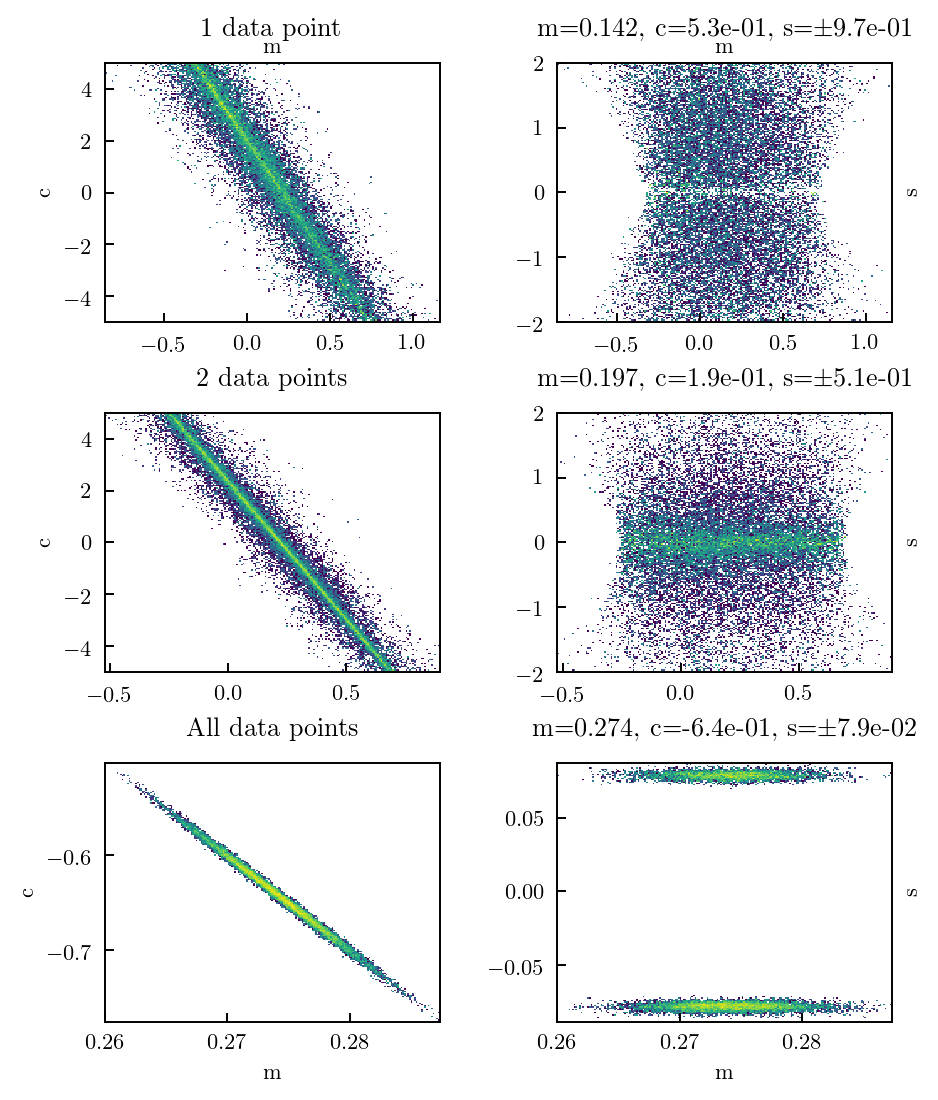

In [9]:
"""Plot MCMC results for Symmetric case"""
plot_mcmc(trace_symm_1p, trace_symm_2p, trace_symm_all, nbins=200, font_size=9, \
              top=0.92, bottom=-0.45, left=0.10, right=0.85, hspace=0.35, wspace=0.35 )

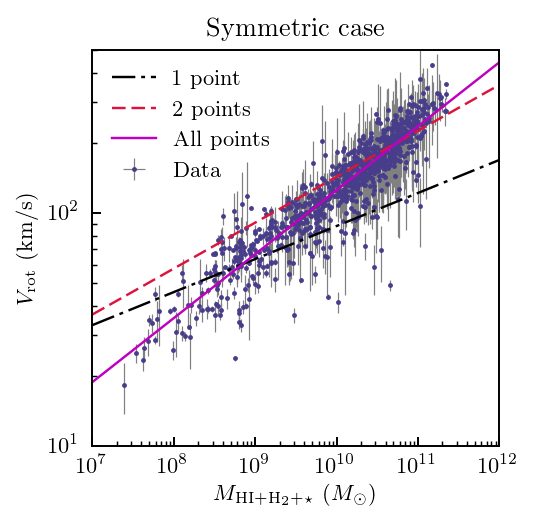

In [10]:
plot_linear_fit(trace_symm_1p, trace_symm_2p, trace_symm_all, title='Symmetric case')

### Comments

* We can see that using 1 points, randomly chosen from the data, gives the widest spread in $\theta$-space, meaning that the parameters are not very well confined, compared with the other two cases. Of course, using all the data provides the most accurate estimation for the parameters of our linear model.

* Also, since the points in the fisrt two cases are randomaly chosen, the results vary from run to run. For instance, for the case where two points are used, if those two points happen to be such that they fit well to the "best" linear fitting we would expect good results. But, if those two points happen to be, say two consecutive points in the data, the fitting in that case would probably not be great.

* Also, trying different priors, we can notice that for the symmetric case the interval we allow $s$ to vary in cannot be very broad for the method to work; this is not the case for the asymmetric posterior. Maybe this is because, in the symmetric case, we assume uniform distribution in $s_\perp$, and not in $s$, so the scatter will be much more severe is we allow $s$ to get large values.

* On selecting these limits for the parameters, we can somewhat estimate an upper limit for $m$, just by studying the scatter plot of the given data. For $s$, it makes sense to keep it not very large since it is a scatter of the data around the fitting line. Finally, $c$ is maybe for difficult to confine, since it is not very easy to estimate the intercept of the line we are trying to fit.

### Marginalized posterior distributions and confidence level

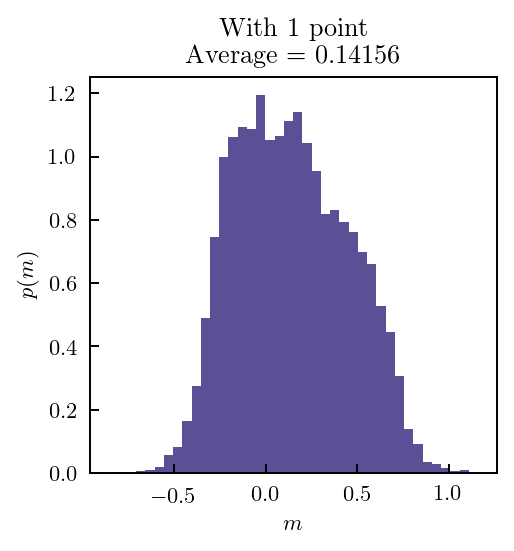

68.00 per cent confidence interval for m using 1 point(s) = [-0.18875 , 0.29195]
95.00 per cent confidence interval for m using 1 point(s) = [-0.36943 , 0.66277]
-------------------------------------------------------------------------------------------


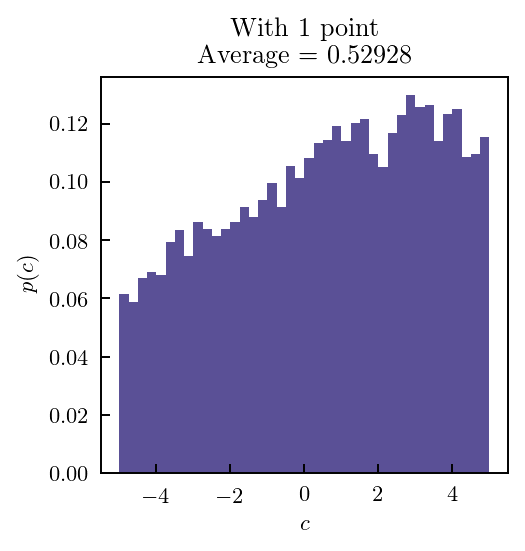

68.00 per cent confidence interval for c using 1 point(s) = [-2.77186 , 2.33196]
95.00 per cent confidence interval for c using 1 point(s) = [-4.58763 , 4.56391]
-------------------------------------------------------------------------------------------


In [11]:
"""Using 1 data point"""
#
#For slope (m)
#
marg_posterior(trace_symm_1p[:,0], xlabel=r'$m$', ylabel=r'$p(m)$', \
               title='With 1 point \n Average = %.5f'%(np.mean(trace_symm_1p[:,0])))
conf_level(trace_symm_1p[:,0], confidence=68., theta='m', Np='1')
conf_level(trace_symm_1p[:,0], confidence=95., theta='m', Np='1')
print('-------------------------------------------------------------------------------------------')
#
#For intercept (c)
#
marg_posterior(trace_symm_1p[:,1], xlabel=r'$c$', ylabel=r'$p(c)$', \
               title='With 1 point \n Average = %.5f'%(np.mean(trace_symm_1p[:,1])))
conf_level(trace_symm_1p[:,1], confidence=68., theta='c', Np='1')
conf_level(trace_symm_1p[:,1], confidence=95., theta='c', Np='1')
print('-------------------------------------------------------------------------------------------')

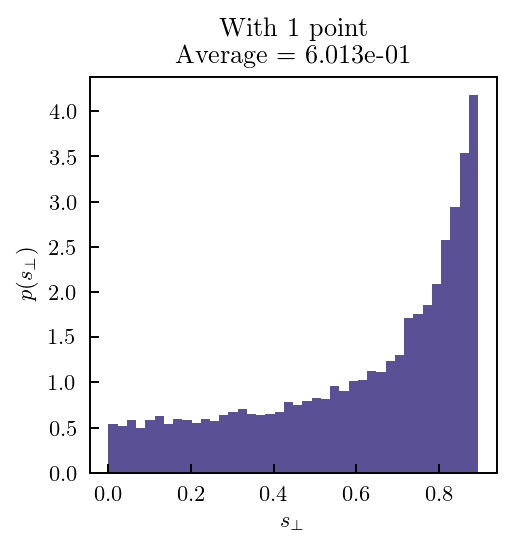

68.00 per cent confidence interval for s_perp using 1 point(s) = [0.28183 , 0.79428]
95.00 per cent confidence interval for s_perp using 1 point(s) = [0.04743 , 0.88298]


In [12]:
#
#For perpendicular intrinsic scatter (s_perp)
#
marg_posterior(abs(trace_symm_1p[:,2] / np.sqrt( 1. + trace_symm_1p[:,2]**2.)), xlabel=r'$s_\perp$', ylabel=r'$p(s_\perp)$', \
               title='With 1 point \n Average = %.3e'%(np.mean(abs(trace_symm_1p[:,2] / np.sqrt( 1. + trace_symm_1p[:,2]**2.)))))
conf_level(abs(trace_symm_1p[:,2] / np.sqrt( 1. + trace_symm_1p[:,2]**2.)), confidence=68., theta='s_perp', Np='1')
conf_level(abs(trace_symm_1p[:,2] / np.sqrt( 1. + trace_symm_1p[:,2]**2.)), confidence=95., theta='s_perp', Np='1')

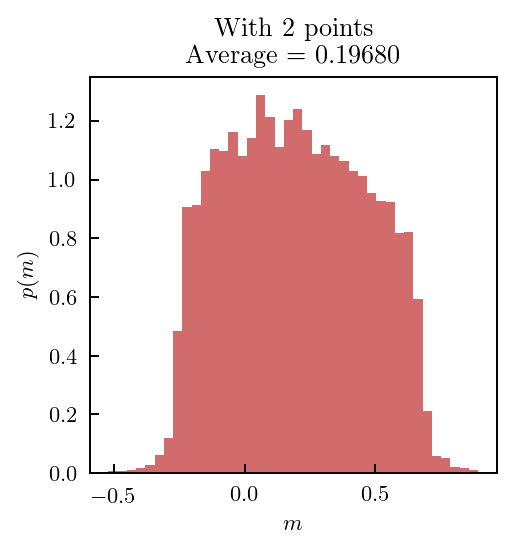

68.00 per cent confidence interval for m using 2 point(s) = [-0.10291 , 0.34685]
95.00 per cent confidence interval for m using 2 point(s) = [-0.24034 , 0.62759]
-------------------------------------------------------------------------------------------


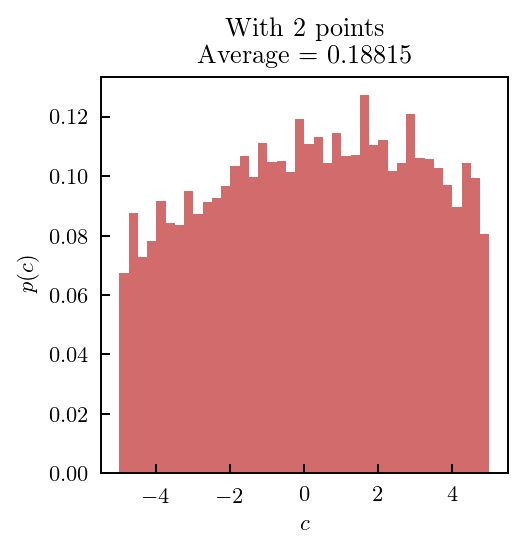

68.00 per cent confidence interval for c using 2 point(s) = [-3.05412 , 1.86452]
95.00 per cent confidence interval for c using 2 point(s) = [-4.64270 , 4.44673]
-------------------------------------------------------------------------------------------


In [13]:
"""Using 2 data points"""
#
#For slope (m)
#
marg_posterior(trace_symm_2p[:,0], xlabel=r'$m$', ylabel=r'$p(m)$', \
               title='With 2 points \n Average = %.5f'%(np.mean(trace_symm_2p[:,0])), color='indianred')
conf_level(trace_symm_2p[:,0], confidence=68., theta='m', Np='2')
conf_level(trace_symm_2p[:,0], confidence=95., theta='m', Np='2')
print('-------------------------------------------------------------------------------------------')
#
#For intercept (c)
#
marg_posterior(trace_symm_2p[:,1], xlabel=r'$c$', ylabel=r'$p(c)$', \
               title='With 2 points \n Average = %.5f'%(np.mean(trace_symm_2p[:,1])), color='indianred')
conf_level(trace_symm_2p[:,1], confidence=68., theta='c', Np='2')
conf_level(trace_symm_2p[:,1], confidence=95., theta='c', Np='2')
print('-------------------------------------------------------------------------------------------')

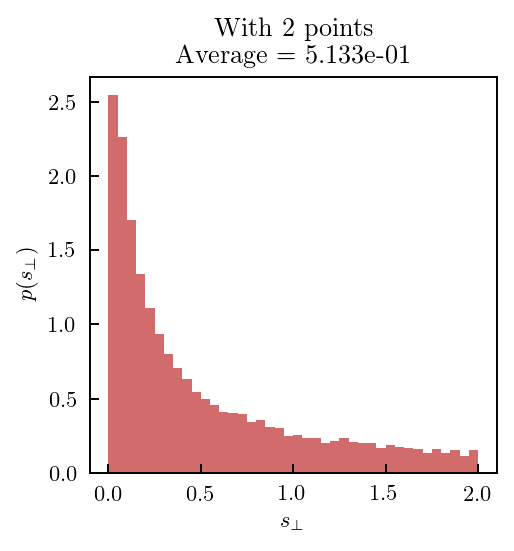

68.00 per cent confidence interval for s_perp using 2 point(s) = [0.06354 , 0.51980]
95.00 per cent confidence interval for s_perp using 2 point(s) = [0.00975 , 0.85549]


In [14]:
#
#For perpendicular intrinsic scatter (s_perp)
#
marg_posterior(abs(trace_symm_2p[:,2]), xlabel=r'$s_\perp$', ylabel=r'$p(s_\perp)$', \
               title='With 2 points \n Average = %.3e'%(np.mean(abs(trace_symm_2p[:,2]))), color='indianred')
conf_level(abs(trace_symm_2p[:,2] / np.sqrt( 1. + trace_symm_2p[:,2]**2.)), confidence=68., theta='s_perp', Np='2')
conf_level(abs(trace_symm_2p[:,2] / np.sqrt( 1. + trace_symm_2p[:,2]**2.)), confidence=95., theta='s_perp', Np='2')

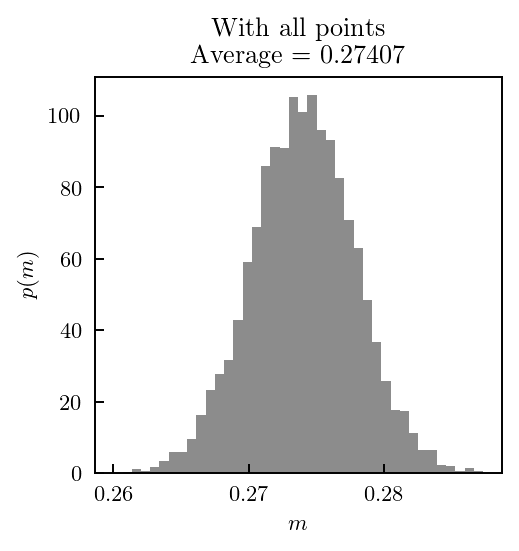

68.00 per cent confidence interval for m using all point(s) = [0.27031 , 0.27586]
95.00 per cent confidence interval for m using all point(s) = [0.26654 , 0.28026]
-------------------------------------------------------------------------------------------


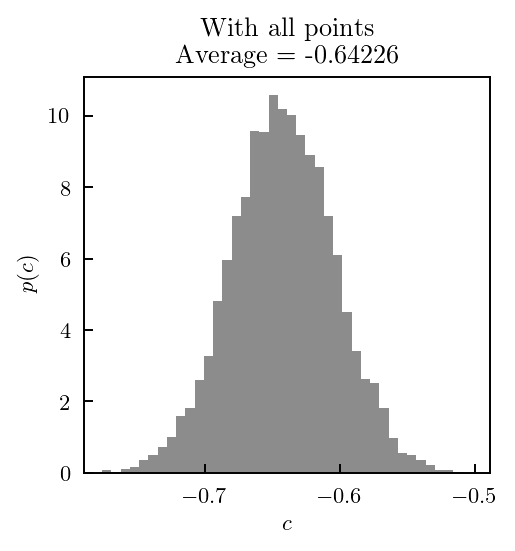

68.00 per cent confidence interval for c using all point(s) = [-0.68001 , -0.62413]
95.00 per cent confidence interval for c using all point(s) = [-0.71813 , -0.57806]
-------------------------------------------------------------------------------------------


In [15]:
"""Using all data points"""
#
#For slope (m)
#
marg_posterior(trace_symm_all[:,0], xlabel=r'$m$', ylabel=r'$p(m)$', \
               title='With all points \n Average = %.5f'%(np.mean(trace_symm_all[:,0])), color='gray')
conf_level(trace_symm_all[:,0], confidence=68., theta='m', Np='all')
conf_level(trace_symm_all[:,0], confidence=95., theta='m', Np='all')
print('-------------------------------------------------------------------------------------------')
#
#For intercept (c)
#
marg_posterior(trace_symm_all[:,1], xlabel=r'$c$', ylabel=r'$p(c)$', \
               title='With all points \n Average = %.5f'%(np.mean(trace_symm_all[:,1])), color='gray')
conf_level(trace_symm_all[:,1], confidence=68., theta='c', Np='all')
conf_level(trace_symm_all[:,1], confidence=95., theta='c', Np='all')
print('-------------------------------------------------------------------------------------------')

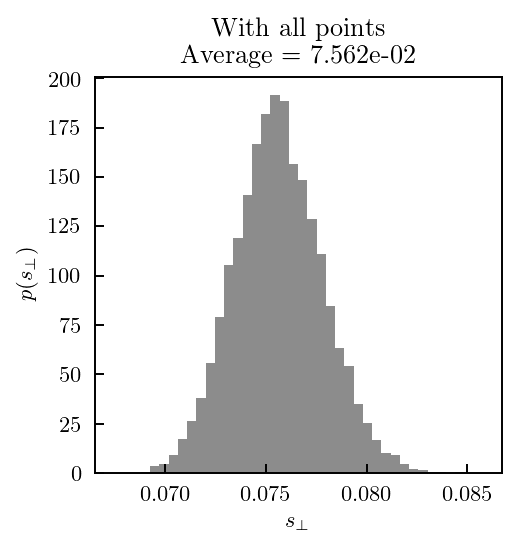

68.00 per cent confidence interval for s_perp using all point(s) = [0.07344 , 0.07660]
95.00 per cent confidence interval for s_perp using all point(s) = [0.07143 , 0.07932]


In [16]:
#
#For perpendicular intrinsic scatter (s_perp)
#
marg_posterior(abs(trace_symm_all[:,2] / np.sqrt( 1. + trace_symm_all[:,0]**2.)), xlabel=r'$s_\perp$', ylabel=r'$p(s_\perp)$', \
               title='With all points \n Average = %.3e'%(np.mean(abs(trace_symm_all[:,2] / np.sqrt( 1. + trace_symm_all[:,0]**2.)))), color='gray')
conf_level(abs(trace_symm_all[:,2] / np.sqrt( 1. + trace_symm_all[:,0]**2.)), confidence=68., theta='s_perp', Np='all')
conf_level(abs(trace_symm_all[:,2] / np.sqrt( 1. + trace_symm_all[:,0]**2.)), confidence=95., theta='s_perp', Np='all')

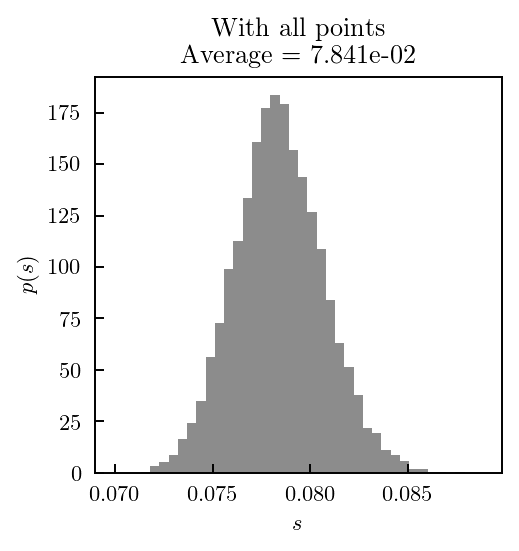

68.00 per cent confidence interval for s using all point(s) = [0.07615 , 0.07941]
95.00 per cent confidence interval for s using all point(s) = [0.07408 , 0.08225]


In [17]:
#
# For intrinsic scatter (s)
#
marg_posterior(abs(trace_symm_all[:,2]), xlabel=r'$s$', ylabel=r'$p(s)$', \
               title='With all points \n Average = %.3e'%(np.mean(abs(trace_symm_all[:,2]))), color='gray')
conf_level(abs(trace_symm_all[:,2]), confidence=68., theta='s', Np='all')
conf_level(abs(trace_symm_all[:,2]), confidence=95., theta='s', Np='all')

# Question 1-2

Below we plot the residuals $y-y_{\rm model}$ and compare them to the scatter, $s$, and its perpendicular projection, $s_\perp$.

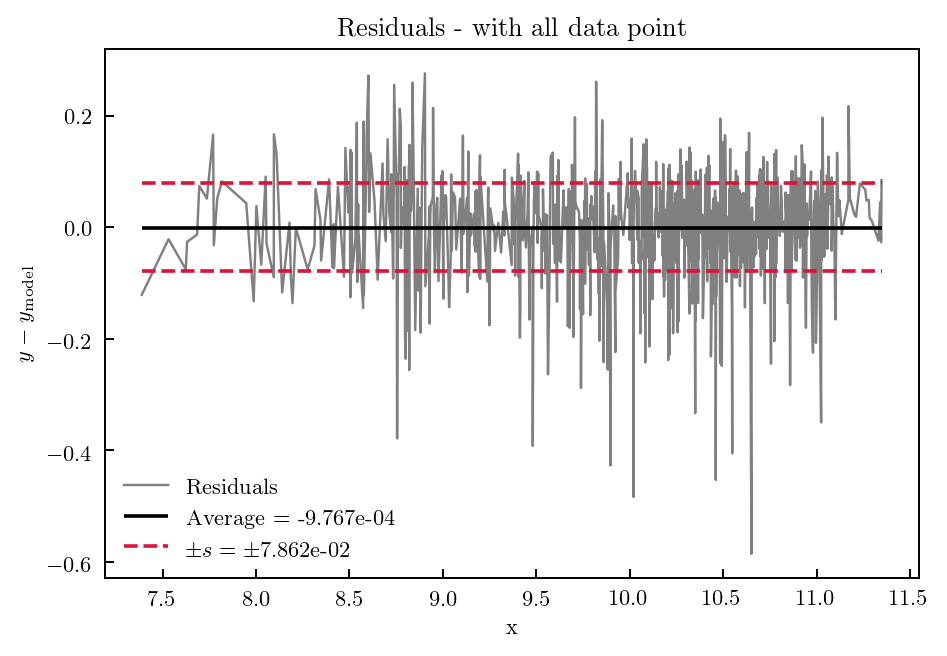

In [18]:
"""Calculation of residuals and plot"""
# residuals based on theta from above using all point
theta_res = theta_calc(trace_symm_all)
data_sort_x = zip(*sorted(zip(data[0],data[1])))

lx_res = np.log10(data_sort_x[0])
ly_res = np.log10(data_sort_x[1])

lres = ly_res - model_lin(theta_res, lx_res)

# plot
plt.plot(lx_res, lres, c='gray', ls='-', linewidth=1., label=r'Residuals', zorder=0)
plt.hlines(y=np.mean(lres), xmin=lx_res.min(), xmax=lx_res.max(), color='k', label=r'Average = %.3e'\
           %(np.mean(lres)), zorder=1)

plt.hlines(y=np.mean(trace_symm_all[:,2][trace_symm_all[:,2] > 0]), linestyles = 'dashed', \
            xmin=lx_res.min(), xmax=lx_res.max(), color='crimson', \
           label=r'$\pm s = \pm$%.3e'%(np.mean(trace_symm_all[:,2][trace_symm_all[:,2] > 0])), zorder=1)
plt.hlines(y=np.mean(trace_symm_all[:,2][trace_symm_all[:,2] < 0]), linestyles = 'dashed', \
            xmin=lx_res.min(), xmax=lx_res.max(), color='crimson', label=r'')

plt.xlabel(r'x')
plt.ylabel(r'$y - y_{\rm model}$')
plt.legend(frameon=False,loc='lower left', fontsize=9)
plt.title(r'Residuals - with all data point', color='k', rotation='horizontal',x=0.5,y=1.0)

plt.show()

### Comments

* Since the slope, $m$, is so small, $s$ and $s_\perp$ are almost equal, as we can also see from the distributions above. Thus, we only plot $s_\perp$ in the figure above.

* The residuals are mostly confined by the $\pm s$, so the contrains on $s$ seem to make sense compared to the residuals.

# Question 1-3

In [19]:
# run MCMC sampler for inversed data
trace_inv = compute_mcmc(log_posterior_symm, data_inv)

Done Sampling in 13.561 s


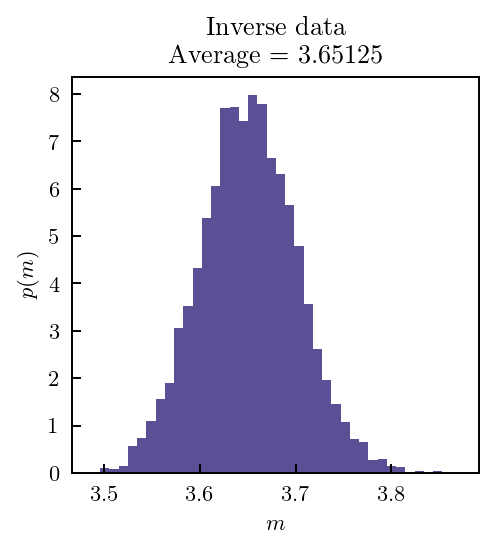

68.00 per cent confidence interval for m using 1 point(s) = [3.60133 , 3.67457]
95.00 per cent confidence interval for m using 1 point(s) = [3.55270 , 3.73573]


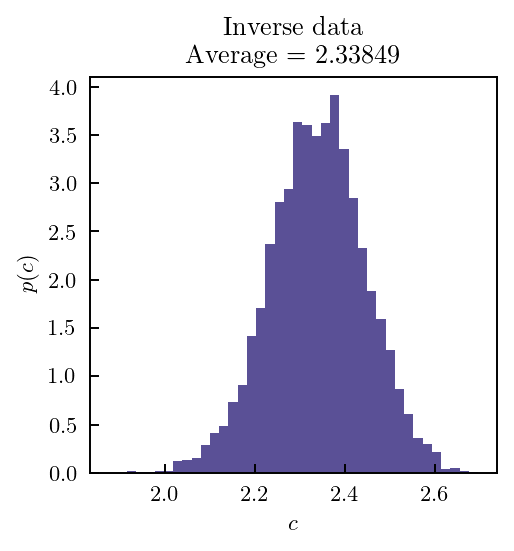

68.00 per cent confidence interval for c using 1 point(s) = [2.23388 , 2.38849]
95.00 per cent confidence interval for c using 1 point(s) = [2.12267 , 2.51167]


In [20]:
"""Marginalized posteriors and comfidense levels"""
#
#For slope (m)
#
marg_posterior(trace_inv[:,0], xlabel=r'$m$', ylabel=r'$p(m)$', \
               title='Inverse data \n Average = %.5f'%(np.mean(trace_inv[:,0])))
conf_level(trace_inv[:,0], confidence=68., theta='m', Np='1')
conf_level(trace_inv[:,0], confidence=95., theta='m', Np='1')
#
#For intercept (c)
#
marg_posterior(trace_inv[:,1], xlabel=r'$c$', ylabel=r'$p(c)$', \
               title='Inverse data \n Average = %.5f'%(np.mean(trace_inv[:,1])))
conf_level(trace_inv[:,1], confidence=68., theta='c', Np='1')
conf_level(trace_inv[:,1], confidence=95., theta='c', Np='1')

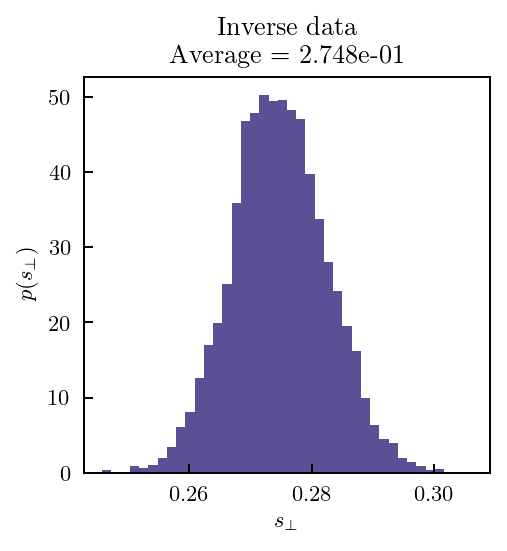

68.00 per cent confidence interval for s_perp using 1 point(s) = [0.26734 , 0.27829]
95.00 per cent confidence interval for s_perp using 1 point(s) = [0.25987 , 0.28774]


In [21]:
#
#For perpendicular intrinsic scatter (s_perp)
#
marg_posterior(abs(trace_inv[:,2] / np.sqrt( 1. + trace_inv[:,2]**2.) ), xlabel=r'$s_\perp$', ylabel=r'$p(s_\perp)$', \
               title='Inverse data \n Average = %.3e'%(np.mean(abs(trace_inv[:,2] / np.sqrt( 1. + trace_inv[:,2]**2.) ))))
conf_level(abs(trace_inv[:,2] / np.sqrt( 1. + trace_inv[:,2]**2.)), confidence=68., theta='s_perp', Np='1')
conf_level(abs(trace_inv[:,2] / np.sqrt( 1. + trace_inv[:,2]**2.)), confidence=95., theta='s_perp', Np='1')

### Inverse data - Symmetric case

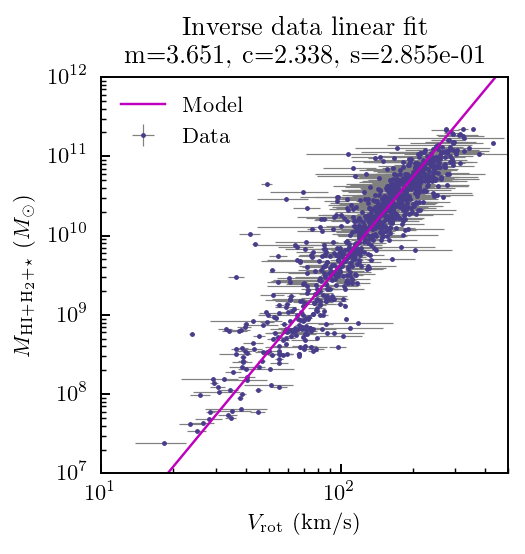

In [22]:
"""Linear fitting with M on the y-axis"""
plt.figure(figsize=(3.,3.))

ymin, ymax = 1.e7, 1.e12
xmin, xmax = 10., 500.
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    
# linear fit model
#-----------------
xfit = np.linspace(xmin,xmax)

# inverse data linear fitting
theta_inv = theta_calc(trace_inv)
plt.plot(xfit, 10**model_lin(theta_inv, np.log10(xfit)), \
            c='m', ls='-', linewidth=1., label=r'Model')

# data
#-----
plt.errorbar(data_inv[0], data_inv[1], xerr=data_inv[2], yerr=data_inv[3],\
                fmt='o', ms=1, elinewidth=0.5, ecolor='gray', \
                c='darkslateblue', label=r'Data', zorder=1)

plt.xlabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.ylabel(r'$M_{\rm HI+H_2+\star}\ {(M_\odot)}$')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.title('Inverse data linear fit \n m=%.3f, c=%.3f, s=%.3e'%(theta_inv[0],theta_inv[1],theta_inv[2]), \
          color='k', rotation='horizontal',x=0.5,y=1.0)

plt.xscale('log'); plt.yscale('log')

plt.show()

In [23]:
"""Comparing confidence regions"""
# For slope
print('Slope')
print('=====')
conf_level(trace_symm_all[:,0], confidence=68., theta='m with initial data', Np='all')
conf_level(1/trace_inv[:,0], confidence=68., theta='1/m with inverted data', Np='all')
print('')
conf_level(trace_symm_all[:,0], confidence=95., theta='m with initial data', Np='all')
conf_level(1/trace_inv[:,0], confidence=95., theta='1/m with inverted data', Np='all')

print('---------------------------------------------------------------------------------- \n \n')

# For intercept
print('Intercept')
print('=========')
conf_level(trace_symm_all[:,1], confidence=68., theta='c with initial data', Np='all')
conf_level(-trace_inv[:,1]/trace_inv[:,0], confidence=68., theta='-c/m with inverted data', Np='all')
print('')
conf_level(trace_symm_all[:,1], confidence=95., theta='c with initial data', Np='all')
conf_level(-trace_inv[:,1]/trace_inv[:,0], confidence=95., theta='-c/m with inverted data', Np='all')

print('---------------------------------------------------------------------------------- \n \n')

# For perpendicular intrinsic scatter
print('Perpendicular intrinsic scatter')
print('===============================')
conf_level(abs(trace_symm_all[:,2] / np.sqrt( 1. + trace_symm_all[:,0]**2.)), confidence=68., theta='c with initial data', Np='all')
conf_level(abs(trace_inv[:,2] / np.sqrt( 1. + trace_inv[:,0]**2.)), confidence=68., theta='-c/m with inverted data', Np='all')
print('')
conf_level(abs(trace_symm_all[:,2] / np.sqrt( 1. + trace_symm_all[:,0]**2.)), confidence=95., theta='c with initial data', Np='all')
conf_level(abs(trace_inv[:,2] / np.sqrt( 1. + trace_inv[:,0]**2.)), confidence=95., theta='-c/m with inverted data', Np='all')

print('----------------------------------------------------------------------------------')

Slope
=====
68.00 per cent confidence interval for m with initial data using all point(s) = [0.27031 , 0.27586]
68.00 per cent confidence interval for 1/m with inverted data using all point(s) = [0.27022 , 0.27566]

95.00 per cent confidence interval for m with initial data using all point(s) = [0.26654 , 0.28026]
95.00 per cent confidence interval for 1/m with inverted data using all point(s) = [0.26646 , 0.28025]
---------------------------------------------------------------------------------- 
 

Intercept
68.00 per cent confidence interval for c with initial data using all point(s) = [-0.68001 , -0.62413]
68.00 per cent confidence interval for -c/m with inverted data using all point(s) = [-0.67867 , -0.62320]

95.00 per cent confidence interval for c with initial data using all point(s) = [-0.71813 , -0.57806]
95.00 per cent confidence interval for -c/m with inverted data using all point(s) = [-0.71611 , -0.57872]
-------------------------------------------------------------------

### Comments

* Using $V_{\rm rot}$ as the x-axis, instead of $M_b$, the slope, $m'$, we get using all points is equal to $1/m$, where $m$ is the prevous slope. Also, the new intercept, $c'$, is approximately equal to $- c/m$, where $c$ the previous intercept. This is what we would expect from theory.

* For intrinsic scatter, it seems that it remains almost the same when using $M_b$ as y and $V_{\rm rot}$ as y, which should be the case.

# Question 1-4

## Asymmetric case

In this case, the likelihood is
\begin{equation}
    \mathcal{L}_i = \frac{1}{\sqrt{2\pi\sigma^2_{\rm tot, i}}}\,\exp\left[-\frac{1}{2}\frac{(y_i-mx_i-c)^2}{\sigma^2_{\rm tot, i}}\right] \; ,
\end{equation}
where $\sigma_{\rm tot,i}^2 = s^2 + m^2 \sigma_{x,i}^2 + \sigma^2_{y,i}$. Therefore,
\begin{equation}
    \ln \mathcal{L} = -\frac{1}{2} \sum\limits_{i=1}^{N} \left[ \ln \left( 2 \pi \sigma_{\rm tot, i}^2 \right) + \frac{(y_i - mx_i - c)^2}{\sigma_{\rm tot,i}^2} \right] \; .
\end{equation}


### Priors

We need priors for each one of the three parameters, $(m,c,\sigma)$, in our model.

* Slope: Lets assume that the slope, $m = \tan \alpha$, varies uniformly from a minimum value, $m_{\min}$, to a maximum one, $m_{\max}$. Then, our prior can be flat, of the form
\begin{equation}
    p(m) \propto 
    \begin{cases}
      m_0, & \text{if}\ m_{\min} < m < m_{\max} \\
      0, & \text{otherwise}
    \end{cases}
\end{equation}
or, since we will use the logarithm of it, 
\begin{equation}
    \ln p(m) \propto 
    \begin{cases}
      \ln m_0, & \text{if}\ m_{\min} < m < m_{\max} \\
      -\infty , & \text{otherwise}
    \end{cases}
\end{equation}
where $m_0$ is a constant.



* Intercept: We will use the same prior for the intercept as with the slope, i.e.
\begin{equation}
    \ln p(c) \propto 
    \begin{cases}
      \ln c_0, & \text{if}\ c_{\min} < c < c_{\max} \\
      -\infty , & \text{otherwise}
    \end{cases}
\end{equation}
where $p_{\min}$ and $p_{\max}$ are the limits we allow for $c$, and $c_0$ is a constant.



* Intrinsic scatter: In the same manner, if $s_{\min}$ and $s_{\max}$ are the limits for intrinsic scatter, 
\begin{equation}
    \ln p(s) \propto 
    \begin{cases}
      \ln s_0, & \text{if}\ s_{\min} < s < s_{\max} \\
      -\infty , & \text{otherwise}
    \end{cases}
\end{equation}
where, $s_0$ is another constant.


Therefore, $\ln p(\boldsymbol{\theta}) = \ln p(m) + \ln p(c) + \ln p(s)$.

In [24]:
def log_prior_asymm(theta):
    """ 
    Log of prior - flat over a large range
    It is the sum of the log of the priors for m, c, s
    
    Input:
    ------
    theta  - vector of parameters (m,c,s)
    
    Output:
    -------
    Log of the flat prior
    """
    m, c, s = theta
    if  abs(m) < 10. and abs(c) < 10. and abs(s) < 3.: 
        m0 = 1./200.; c0 = 1./200.; s0 = 1./200. 
        # if inside allowed range
        return np.log(m0) + np.log(c0) + np.log(s0)
    else: 
        # if outside allowed range
        return -np.inf # log(0)
    
def log_likelihood_asymm(theta, data, model=model_lin):
    """ 
    Logarithm of Likelihood function L - Asymmetric case
    
    Inputs:
    -------
    theta  - vector of parameters (m,c,s)
    data   - the data we use
    model  - fitting model
    
    Output:
    -------
    The result of the logarithm of the likelihood
    """
    m, c, s = theta
    
    x, y, sigma_x, sigma_y = data
    lx, ly = np.log10(x), np.log10(y)
    
    lsigma_fact = np.log(10.) ** -1.
    lsigma_x, lsigma_y = lsigma_fact * sigma_x/x, lsigma_fact * sigma_y/y 
    
    lsigma_tot2 = lsigma_y**2 + m**2 * lsigma_x**2 + s**2
    
    lyM = model(theta, lx)
    lfact1 = np.log(2 * np.pi * lsigma_tot2)   # ln(2*pi*sigma_tot^2)
    lfact2 = (ly - lyM) ** 2 / lsigma_tot2     # ln(exp(-(y-m*x-c)^2/sigma_tot^2))
    return -0.5 * np.sum(lfact1 + lfact2)      # -(1/2) * (fact_1 + fact_2)

def log_posterior_asymm(theta, data=data):
    """ln of posterior"""
    theta = np.asarray(theta) # parameters array
    return log_prior_asymm(theta) + log_likelihood_asymm(theta, data)

### MCMC sampling - Asymmetric case

In [25]:
""" Using 1 data point """
# randomly choose 1 data point
ind_1p = rnd.randint(0,len(data[0]))
data_1p = np.array([data[0][ind_1p], data[1][ind_1p],\
                         data[2][ind_1p], data[3][ind_1p]])

# run MCMC sampler
print('Sampling using 1 point...')
trace_asymm_1p = compute_mcmc(log_posterior_asymm, data=data_1p)
print('=========================')

""" Using 2 data points """
# randomly choosen 2 data points
ind_2p = rnd.randint(0,len(data[0]),2)
data_2p = np.array([data[0][ind_2p], data[1][ind_2p],\
                         data[2][ind_2p], data[3][ind_2p]])

# run MCMC sampler
print('Sampling using 2 points...')
trace_asymm_2p = compute_mcmc(log_posterior_asymm, data=data_2p)
print('==========================')

""" Using all data points """
# run MCMC sampler
print('Sampling using all points...')
trace_asymm_all = compute_mcmc(log_posterior_asymm)

Sampling using 1 point...
Done Sampling in 2.013 s
Sampling using 2 points...
Done Sampling in 2.955 s
Sampling using all points...
Done Sampling in 13.054 s


### Plotting the results for the Asymmetric case

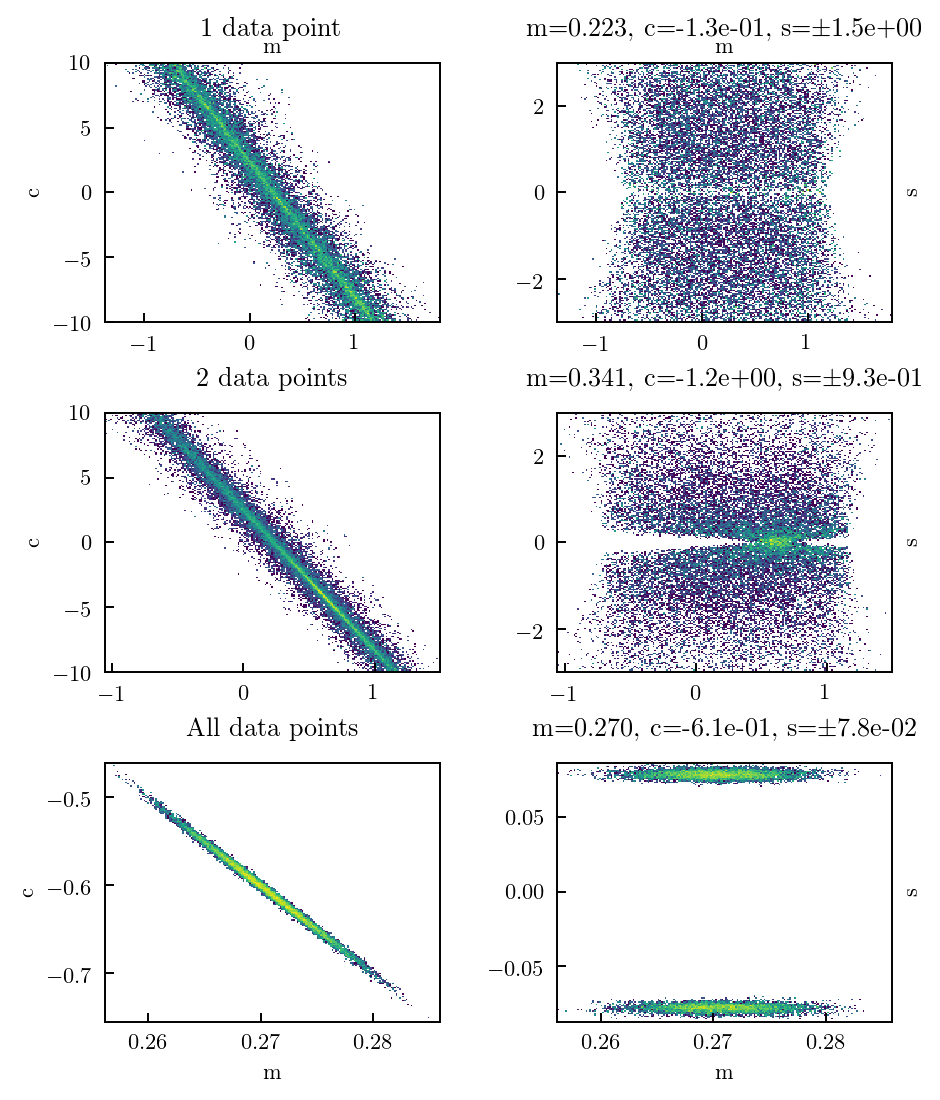

In [26]:
"""Plot MCMC results for Asymmetric case"""
plot_mcmc(trace_asymm_1p, trace_asymm_2p, trace_asymm_all, nbins=200, font_size=9, \
              top=0.92, bottom=-0.45, left=0.10, right=0.85, hspace=0.35, wspace=0.35 )

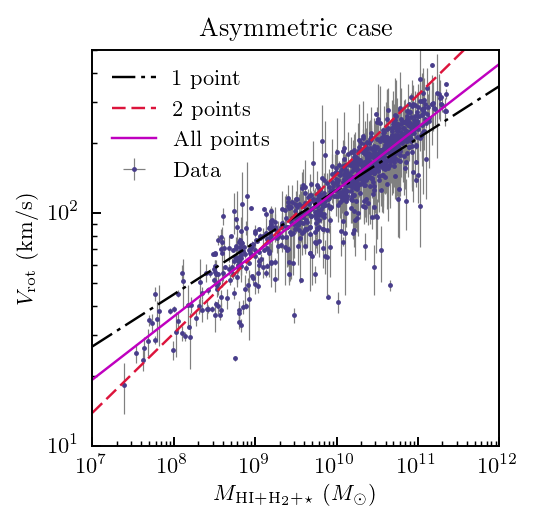

In [27]:
plot_linear_fit(trace_asymm_1p, trace_asymm_2p, trace_asymm_all, title='Asymmetric case')

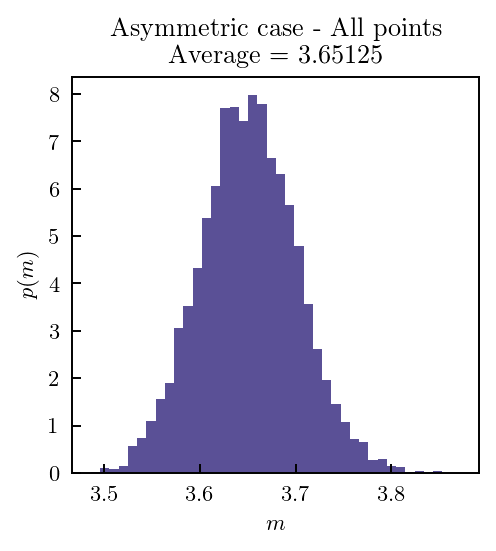

68.00 per cent confidence interval for m using 1 point(s) = [0.26657 , 0.27237]
95.00 per cent confidence interval for m using 1 point(s) = [0.26256 , 0.27708]


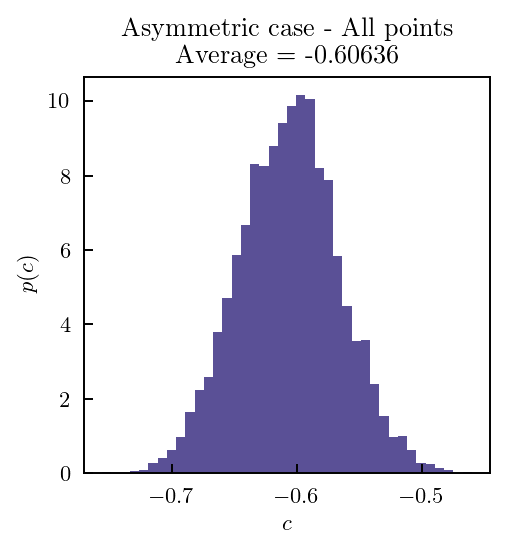

68.00 per cent confidence interval for c using 1 point(s) = [-0.64663 , -0.58792]
95.00 per cent confidence interval for c using 1 point(s) = [-0.68465 , -0.54051]


In [28]:
"""Marginalized posteriors and comfidense levels"""
#
#For slope (m)
#
marg_posterior(trace_inv[:,0], xlabel=r'$m$', ylabel=r'$p(m)$', \
               title='Asymmetric case - All points \n Average = %.5f'%(np.mean(trace_inv[:,0])))
conf_level(trace_asymm_all[:,0], confidence=68., theta='m', Np='1')
conf_level(trace_asymm_all[:,0], confidence=95., theta='m', Np='1')
#
#For intercept (c)
#
marg_posterior(trace_asymm_all[:,1], xlabel=r'$c$', ylabel=r'$p(c)$', \
               title='Asymmetric case - All points \n Average = %.5f'%(np.mean(trace_asymm_all[:,1])))
conf_level(trace_asymm_all[:,1], confidence=68., theta='c', Np='1')
conf_level(trace_asymm_all[:,1], confidence=95., theta='c', Np='1')

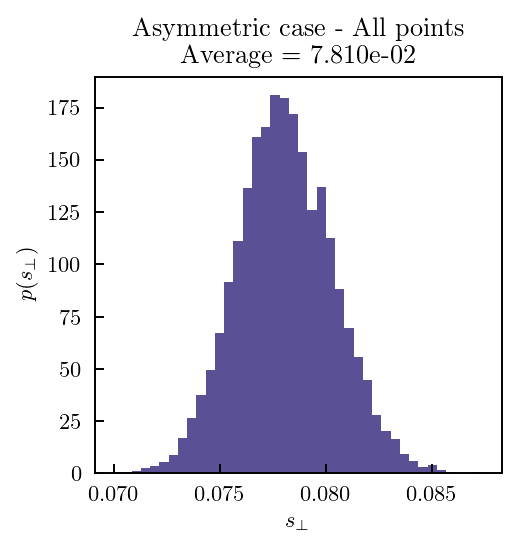

68.00 per cent confidence interval for s_perp using 1 point(s) = [0.07589 , 0.07909]
95.00 per cent confidence interval for s_perp using 1 point(s) = [0.07380 , 0.08189]


In [29]:
#
#For perpendicular intrinsic scatter (s_perp)
#
marg_posterior(abs(trace_asymm_all[:,2]/ np.sqrt( 1. + trace_asymm_all[:,2]**2.)), xlabel=r'$s_\perp$', ylabel=r'$p(s_\perp)$', \
               title='Asymmetric case - All points \n Average = %.3e'%(np.mean(abs(trace_asymm_all[:,2]/ np.sqrt( 1. + trace_asymm_all[:,2]**2.)))))
conf_level(abs(trace_asymm_all[:,2] / np.sqrt( 1. + trace_asymm_all[:,2]**2.)), confidence=68., theta='s_perp', Np='1')
conf_level(abs(trace_asymm_all[:,2] / np.sqrt( 1. + trace_asymm_all[:,2]**2.)), confidence=95., theta='s_perp', Np='1')

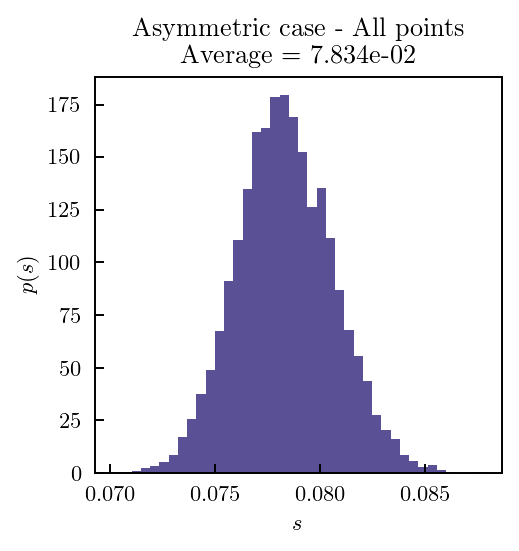

68.00 per cent confidence interval for s using all point(s) = [0.07611 , 0.07934]
95.00 per cent confidence interval for s using all point(s) = [0.07400 , 0.08217]


In [30]:
#
# For intrinsic scatter (s)
#
marg_posterior(abs(trace_asymm_all[:,2]), xlabel=r'$s$', ylabel=r'$p(s)$', \
               title='Asymmetric case - All points \n Average = %.3e'%(np.mean(abs(trace_asymm_all[:,2]))))
conf_level(abs(trace_asymm_all[:,2]), confidence=68., theta='s', Np='all')
conf_level(abs(trace_asymm_all[:,2]), confidence=95., theta='s', Np='all')

### Inverse data - Asymmetric case

In [31]:
# run MCMC sampler
trace_inv_asymm = compute_mcmc(log_posterior_asymm, data_inv)

Done Sampling in 13.044 s


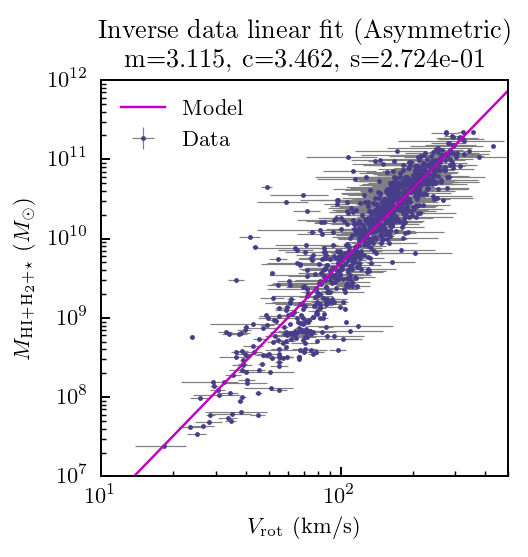

In [32]:
"""Linear fitting with M on the y-axis, for asymmetric case, using all data points"""
plt.figure(figsize=(3.,3.))

ymin, ymax = 1.e7, 1.e12
xmin, xmax = 10., 500.
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    
# linear fit model
#-----------------
xfit = np.linspace(xmin,xmax)

# inverse data linear fitting
theta_inv_asymm = theta_calc(trace_inv_asymm)
plt.plot(xfit, 10**model_lin(theta_inv_asymm, np.log10(xfit)), \
            c='m', ls='-', linewidth=1., label=r'Model')

# data
#-----
plt.errorbar(data_inv[0], data_inv[1], xerr=data_inv[2], yerr=data_inv[3],\
                fmt='o', ms=1, elinewidth=0.5, ecolor='gray', \
                c='darkslateblue', label=r'Data', zorder=1)

plt.xlabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.ylabel(r'$M_{\rm HI+H_2+\star}\ {(M_\odot)}$')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.title('Inverse data linear fit (Asymmetric) \n m=%.3f, c=%.3f, s=%.3e'\
          %(theta_inv_asymm[0],theta_inv_asymm[1],theta_inv_asymm[2]), \
          color='k', rotation='horizontal',x=0.5,y=1.0)

plt.xscale('log'); plt.yscale('log')

plt.show()

In [33]:
"""Comparing confidence regions for the Asymmetric case"""
# For slope
print('Slope')
print('=====')
conf_level(trace_asymm_all[:,0], confidence=68., theta='m with initial data', Np='all')
conf_level(1/trace_inv_asymm[:,0], confidence=68., theta='1/m with inverted data', Np='all')
print('')
conf_level(trace_asymm_all[:,0], confidence=95., theta='m with initial data', Np='all')
conf_level(1/trace_inv_asymm[:,0], confidence=95., theta='1/m with inverted data', Np='all')

print('---------------------------------------------------------------------------------- \n \n')

# For intercept
print('Intercept')
print('=========')
conf_level(trace_asymm_all[:,1], confidence=68., theta='c with initial data', Np='all')
conf_level(-trace_inv_asymm[:,1]/trace_inv_asymm[:,0], confidence=68., theta='-c/m with inverted data', Np='all')
print('')
conf_level(trace_asymm_all[:,1], confidence=95., theta='c with initial data', Np='all')
conf_level(-trace_inv_asymm[:,1]/trace_inv_asymm[:,0], confidence=95., theta='-c/m with inverted data', Np='all')

print('---------------------------------------------------------------------------------- \n \n')

# For perpendicular intrinsic scatter
print('Perpendicular intrinsic scatter')
print('===============================')
conf_level(abs(trace_asymm_all[:,2] / np.sqrt( 1. + trace_asymm_all[:,0]**2.)), confidence=68., theta='c with initial data', Np='all')
conf_level(abs(trace_inv_asymm[:,2] / np.sqrt( 1. + trace_inv_asymm[:,0]**2.)), confidence=68., theta='-c/m with inverted data', Np='all')
print('')
conf_level(abs(trace_asymm_all[:,2] / np.sqrt( 1. + trace_asymm_all[:,0]**2.)), confidence=95., theta='c with initial data', Np='all')
conf_level(abs(trace_inv_asymm[:,2] / np.sqrt( 1. + trace_inv_asymm[:,0]**2.)), confidence=95., theta='-c/m with inverted data', Np='all')

print('----------------------------------------------------------------------------------')

Slope
=====
68.00 per cent confidence interval for m with initial data using all point(s) = [0.26657 , 0.27237]
68.00 per cent confidence interval for 1/m with inverted data using all point(s) = [0.31660 , 0.32309]

95.00 per cent confidence interval for m with initial data using all point(s) = [0.26256 , 0.27708]
95.00 per cent confidence interval for 1/m with inverted data using all point(s) = [0.31217 , 0.32905]
---------------------------------------------------------------------------------- 
 

Intercept
68.00 per cent confidence interval for c with initial data using all point(s) = [-0.64663 , -0.58792]
68.00 per cent confidence interval for -c/m with inverted data using all point(s) = [-1.15715 , -1.09114]

95.00 per cent confidence interval for c with initial data using all point(s) = [-0.68465 , -0.54051]
95.00 per cent confidence interval for -c/m with inverted data using all point(s) = [-1.20633 , -1.03751]
-------------------------------------------------------------------

### Comments

* In this case, as we would expect, the credible regions differ significanlty.

* Also, we can not retrieve the slope of the initial-data fit using the transfomrmation $1/m$ to the fit with the inversed data. This is the case for the intercept also.

# Exercise 3

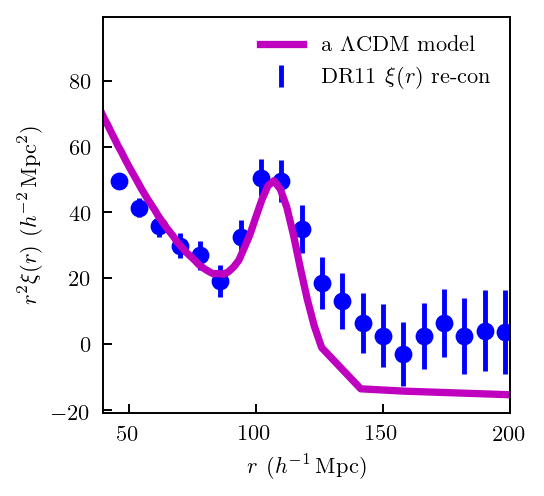

In [36]:
def read_DR11_xi():
    """
    Reads DR11 BOSS corr. function for LRG galaxies and corresponding covariance matrix
    returns r, xi vectors and covij = matrix lxl where l=len(r)=len(xi)
    covij[i][j] contains covariance of errors of xi(r_i) and xi(r_j)
    """
    # read in 2-point correlation function and its covariance matrix
    corrfunction_dir = '/home/georgez/ownCloud/Courses/Computational Astrophysics/a330f17/data/Anderson_2013_CMASSDR11_corrfunction_x0x2_postrecon.dat'
    postrecon_dir = '/home/georgez/ownCloud/Courses/Computational Astrophysics/a330f17/data/Anderson_2013_CMASSDR11_corrfunction_cov_x0x2_postrecon.dat'
    r,xi = np.loadtxt(corrfunction_dir,usecols=(0,1), unpack=True)
    ri, rj, covij = np.loadtxt(postrecon_dir, usecols=(0,1,2), unpack=True)

    lmat = np.sqrt(len(ri))
    covij = np.reshape(covij,(lmat,lmat))
    return r, xi, covij

r, xi, covij = read_DR11_xi()
data = np.array([r, xi])

from numpy.linalg import inv
covij_inv = inv(covij)

xir2 = xi*r*r

# read in theoretical xi(r) computed using integral in HW2
xi_dir = '/home/georgez/ownCloud/Courses/Computational Astrophysics/a330f17/data/xi_out.dat'
rm, xim = np.loadtxt(xi_dir,usecols=(0,1), unpack=True)

ximr2 = xim*rm*rm*2.2 # multiply by arbitrary bias 
exir2 = np.sqrt(np.diagonal(covij))*r*r

#
# plot corr. function along with a model
#
fig1 = plt.figure(figsize=(3,3))

plt.xlim(40.0,200.0)
plt.errorbar(r, xir2, yerr=exir2, linestyle="None" ,marker="None",ecolor='b',lw=2,capthick=2,label=r'DR11 $\xi(r)$ re-con')
plt.scatter(r, xir2, c='b',s=40)

plt.plot(rm,ximr2, c='m', lw=3.0, label=r'a $\Lambda$CDM model')
#
plt.xlabel(r'$r\ (h^{-1}\rm\, Mpc)$')
plt.ylabel(r'$r^2\xi(r)\ (h^{-2}\,\rm Mpc^2)$')
plt.legend(loc='upper right', frameon=False, fontsize=9)
#
plt.show()

In [34]:
def Rmm(a, b, func, m, **kwargs):
    """
    Auxiliary function computing tableau entries for Romberg integration
    using recursive relation, but implemented non-recursively
    
    Parameters:
    -----------------
    func - python function object
            function to integrate
    a, b - floats
            integration interval            
    m    - integer
            iteration level; accuracy order will be equal to 2(m+1)
            in this implementation there is no need for k on input
            
    kwargs - python dictionary 
            array of keyword arguments to be passed to the integrated function
            
    Returns:
    ---------
    
    I(m)   - float
              estimate of the integral using scheme of order 2*m+2
    I(m-1) - float
              estimate of the integral using scheme of order 2*m
    """
    assert(m >= 0)
    
    ba = b - a;
    hk = ba / 2**(np.arange(m+1)) # vector of step sizes

    Rkm = np.zeros((m+1,m+1)) 

    Rkm[0,0] = 0.5 * ba * (func(a, **kwargs) + func(b, **kwargs))
    
    #if m == 0: 
    #    return Rkm[0,0], 0.
    
    for k in range(1,m+1):
        # first compute R[k,0]
        trapzd_sum = 0.
        for i in range(1, 2**(k-1)+1):
            trapzd_sum += func(a + (2*i-1)*hk[k], **kwargs)
            
        # we can reuse Rkm[k-1,0] but we need to divide it by 2 to account for step decrease 
        Rkm[k,0] = Rkm[k-1,0] * 0.5 + hk[k] * trapzd_sum
        
        # then fill the tableau up to R[k,k]
        for md in range(1,k+1):
            fact = 4.**md
            Rkm[k,md] = (fact * Rkm[k,md-1] - Rkm[k-1,md-1])/(fact - 1)

          
    return Rkm[m,m], Rkm[m,m-1] # return the desired approximation and best one of previous order 

def romberg2(func, a, b, rtol = 1.e-4, mmax = 8, verbose = False, **kwargs):
    """
    Romberg integration scheme to evaluate
            int_a^b func(x)dx 
    using recursive relation to produce higher and higher order approximations
    
    Code iterates from m=0, increasing m by 1 on each iteration.
    Each iteration computes the integral using scheme of 2(m+2) order of accuracy 
    Routine checks the difference between approximations of successive orders
    to estimate error and stops when a desired relative accuracy 
    tolerance is reached.

    Parameters:
    --------------------------------
    
    func - python function object
            function to integrate
    a, b - floats
            integration interval
    rtol - float 
            fractional tolerance of the integral estimate
    mmax - integer
            maximum number of iterations to do 
    verbose - logical
            if True print intermediate info for each iteration
    kwargs - python dictionary
             a list of parameters with their keywords to pass to func
               
    Returns:
    ---------------------------------
    I    - float
           estimate of the integral for input f, [a,b] and rtol
    err  - float 
           estimated fractional error of the estimated integral

    """
    assert(a < b)
    
    for m in range(1, mmax):
        Rmk_m, Rmk_m1 = Rmm(a, b, func, m, **kwargs)
            
        if Rmk_m == 0:
            Rmk_m = 1.e-300 # guard against division by 0 
            
        etol = 1.2e-16 + rtol*np.abs(Rmk_m)
        err = np.abs(Rmk_m-Rmk_m1)

        if verbose: 
            print("m = %d, integral = %.6e, prev. order = %.6e, frac. error estimate = %.3e"%(m, Rmk_m, Rmk_m1, err/Rmk_m))
            #print a, b, m, Rmk_m, Rmk_m1, err

        if (m>0) and (np.abs(err) <= etol):
            return Rmk_m, err/Rmk_m
        
    print("!!! Romberg warning: !!!")
    print("!!! maximum of mmax=%d iterations reached, abs(err)=%.3e, > required error rtol = %.3e"%(mmax, np.abs(err/Rmk_m), rtol))
    return Rmk_m, err/Rmk_m

## Part 1

In [37]:
"""Cosmology setup"""
from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.274, 'Ob0': 0.0224, 'sigma8': 0.8, 'ns': 0.95}
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = False

# constants and normalization constants
h = 0.7
Mpc = 3.0857e+16
Msun = 1.99e+30; Mnorm = Msun/h

In [38]:
"""Power spectrum integration setup to derive xi^fit"""
def xi_int(lk, **kwargs):
    """Integrant for power spectrum computation""" 
    from scipy.special import spherical_jn
    k = 10.**lk; x = k * kwargs["R"];
    cosmo = kwargs["cosmo"]
    Pk = cosmo.matterPowerSpectrum(k, 'eh98')
    return  k**3 * Pk * np.exp(-(kwargs["Rc"]*k)**2) * spherical_jn(0,x)

def xi_r(r, rtol=1.e-6, **kwargs):
    """
    Computation of 2-point correlation function of matter in the universe
    Rc  = is the cutoff radius below which the integrand is suppressed exponentially;
            if zero, the integral is computed by splitting k into intervals corresponding to oscillations 
    """
    lkmin = kwargs["lkmin"]; lkmax = kwargs["lkmax"]    

    xi_r, err_r = romberg2(xi_int, lkmin, lkmax,  rtol=rtol, **kwargs)
    xi_r *= np.log(10.)/(2.*np.pi**2)
    err_r *= np.log(10.)/(2.*np.pi**2)
    return xi_r, err_r

def compute_xi_r(r, fcut, rtol, cosmo, lkmin, lkmax, mmax):

    xi_dummy = np.zeros_like(r); err_dummy = np.zeros_like(r)
    
    for i, rd in enumerate(r):
        rcutoff = fcut * rd
        lkmax = np.log10(2.0 * np.pi / rcutoff)

        kwargs = {"R":rd, "cosmo":cosmo, "Rc":rcutoff, "lkmin":lkmin, "lkmax":lkmax, "mmax":mmax}

        xi_dummy[i], err_dummy[i] = xi_r(rd, rtol=rtol, **kwargs) 

    return xi_dummy, err_dummy

### Model

Our model is the additive polynomial
$$ \xi^{\rm fit}(r) = B_\xi ^2 \xi^{\rm mod} (\alpha r) + A^\xi (r) \; ,$$
where 
$$ A^\xi = \frac{\alpha_1}{r^2} + \frac{\alpha_2}{r} + \alpha_3 \; .$$

To find $\xi^{\rm mod}$ we need to calculate
$$ \xi^{\rm mod}(r) = \int_{k_{\min}}^{k_{\max}} \frac{k^2 dk}{2 \pi^2} P(k) j_0(k r) e^{-r_c^2 k^2} = \frac{\ln (10)}{2\pi^2} \int_{\log_{10} k_{\min}}^{\log_{10} k_{\max}} k^3 P(k) j_0(k r) e^{-r_c^2 k^2} du \; , $$
where we have transformed the integral to log space, $k = 10^u$. $P(k)$ is the power spectrum given by colossus, while $j_0(k r)$ is a oscillatory transform kernel. Finally, $r_c$ is a cutoff radius to produce accurate results from the numerical integration.


The parameters vector is
$$ \boldsymbol{\theta} = (\alpha, B_\xi^2, \alpha_1, \alpha_2, \alpha_3) \; . $$

### Priors

From the form of $\xi^{\rm fit}$, we can make the following observations:

* $\xi^{\rm mod}$ must have the correct form that fits the data. From the figure below we see that this seems to be the case.

* $\alpha$ shifts $\xi^{\rm mod}$, and has probably values around $1$. We select a Gaussian prior around $1$ and $\sigma_\alpha = 0.1$.

* $B_\xi^2$ raises $\xi^{\rm mod}$ to higher values, and thus should have values of the order of $2-3$. We will select a Gaussian prior around $2.5$ and with $\sigma_{B_\xi^2} = 1$.

* $A^\xi$ depends on $\alpha_1$, $\alpha_2$, and $\alpha_3$. For them we will choose flat priors, since we do not know much about them.

### Likelihood

We write the log of the likelihood as
$$ \ln \mathcal{L} \propto -\frac{1}{2}(\mathbf{m}-\mathbf{d})^{\rm T}\mathbf{C}^{-1}(\mathbf{m}-\mathbf{d}) \; ,$$
where $\mathbf{m}$ is the model values of $\xi^{\rm fit}$, and $\mathbf{d}$ is the data provided.

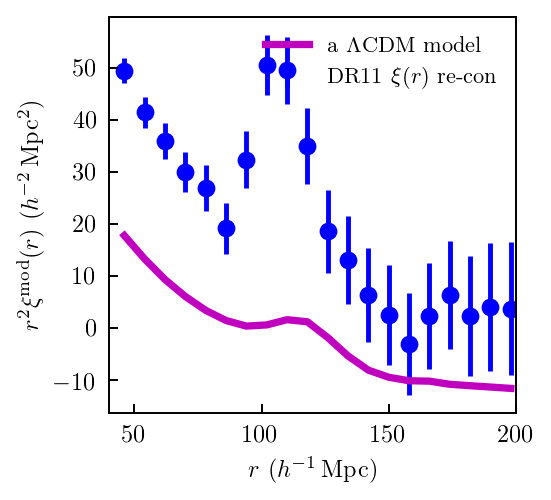

In [369]:
#
# plot of xi^mod
#
fig1 = plt.figure(figsize=(3,3))

plt.xlim(40.0,200.0)
plt.errorbar(r, xir2, yerr=exir2, linestyle="None" ,marker="None",ecolor='b',lw=2,capthick=2,label=r'DR11 $\xi(r)$ re-con')
plt.scatter(r, xir2, c='b',s=40)

plt.plot(r, r*r*xi_mod_spl(r), c='m', lw=3.0, label=r'a $\Lambda$CDM model')
#
plt.xlabel(r'$r\ (h^{-1}\rm\, Mpc)$')
plt.ylabel(r'$r^2\xi^{\rm mod}(r)\ (h^{-2}\,\rm Mpc^2)$')
plt.legend(loc='upper right', frameon=False, fontsize=9)
#
plt.show()

In [43]:
"""Calculates xi^mod to include in fitting model, xi^fit"""
fcut = 1.e-3; rtol = 1.e-8
lkmin = -2; lkmax = 5

# splines for xi^mod(r)
xi_mod, err_mod = compute_xi_r(r, fcut, rtol, cosmo, lkmin, lkmax, mmax=30)
xi_mod_spl = UnivariateSpline(r, xi_mod, s=0.)

In [44]:
def xi_fit(theta, r):
    """Fitting model definition"""
    alpha, Bxi2, alpha1, alpha2, alpha3 = theta
    Axi = alpha1/r**2 + alpha2/r + alpha3
    return Axi + Bxi2 * xi_mod_spl(alpha*r)

def log_prior(theta):
    """ 
    Log of prior
    ============
    Flat priors for a1, a2, a3
    Gaussian prior for a, Bxi^2
    
    Input:
    ------
    theta  - vector of parameters (a, Bxi^2, a1, a2, a3)
    
    Output:
    -------
    Log of prior
    """
    alpha, Bxi2, alpha1, alpha2, alpha3 = theta
    
    sigma_alpha = 0.15; mu_alpha = 1.
    sigma_B = 2.5; mu_B = 1.
    
    if  abs(alpha) < 10. and \
        Bxi2 > 0. and Bxi2 < 20. and \
        abs(alpha1) < 5. and \
        abs(alpha2) < 50. and \
        abs(alpha3) < 5.:
        # if inside allowed range 
        return  -(len(theta)-2) * np.log(200.) \
                - 0.5 * ( np.log(2*np.pi*sigma_alpha**2) + (alpha-mu_alpha)**2 / sigma_alpha**2 ) \
                - 0.5 * ( np.log(2*np.pi*sigma_B**2) + (Bxi2-mu_B)**2 / sigma_B**2 )
    else: 
        # if outside allowed range
        return -np.inf # log(0)
    
def log_likelihood(theta, data, model=xi_fit):
    from numpy.linalg import inv
    """ 
    Logarithm of Likelihood function
    
    Inputs:
    -------
    theta  - vector of parameters (a, Bxi^2, a1, a2, a3)
    data   - the data we use
    model  - fitting model
    
    Output:
    -------
    ln of likelihood
    """
    r, xi = data
    # m-d and (m-d)^T
    md = model(theta, r) - xi
    mdt = md.transpose()
    return -0.5 * md.dot(covij_inv).dot(mdt)

def log_posterior(theta, data=data, model=xi_fit):
    """ln of posterior"""
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

In [45]:
"""Do the sampling using emcee"""
# run MCMC sampler
trace_xi = compute_mcmc(log_posterior, data=data, degree=4)

# theta vector
theta_xi = np.array([np.mean(trace_xi[:,0]),np.mean(trace_xi[:,1]),\
                      np.mean(trace_xi[:,2]),np.mean(trace_xi[:,3]),np.mean(trace_xi[:,4])])

Done Sampling in 3.816 s


### Plotting of marginalized ditributions from sampling chains

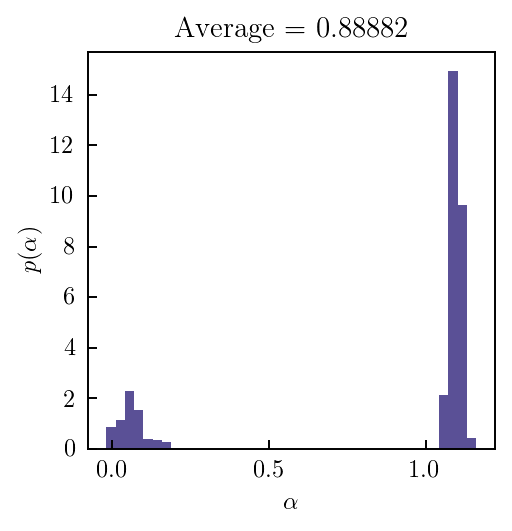

68.00 per cent confidence interval for alpha using all point(s) = [0.08684 , 1.09976]
95.00 per cent confidence interval for alpha using all point(s) = [0.01098 , 1.12112]


In [545]:
#
# For alpha, the dilation parameter
#
marg_posterior(trace_xi[:,0], xlabel=r'$\alpha$', ylabel=r'$p(\alpha)$', \
               title='Average = %.5f'%(np.mean(trace_xi[:,0])))
conf_level(trace_xi[:,0], confidence=68., theta='alpha', Np='all')
conf_level(trace_xi[:,0], confidence=95., theta='alpha', Np='all')

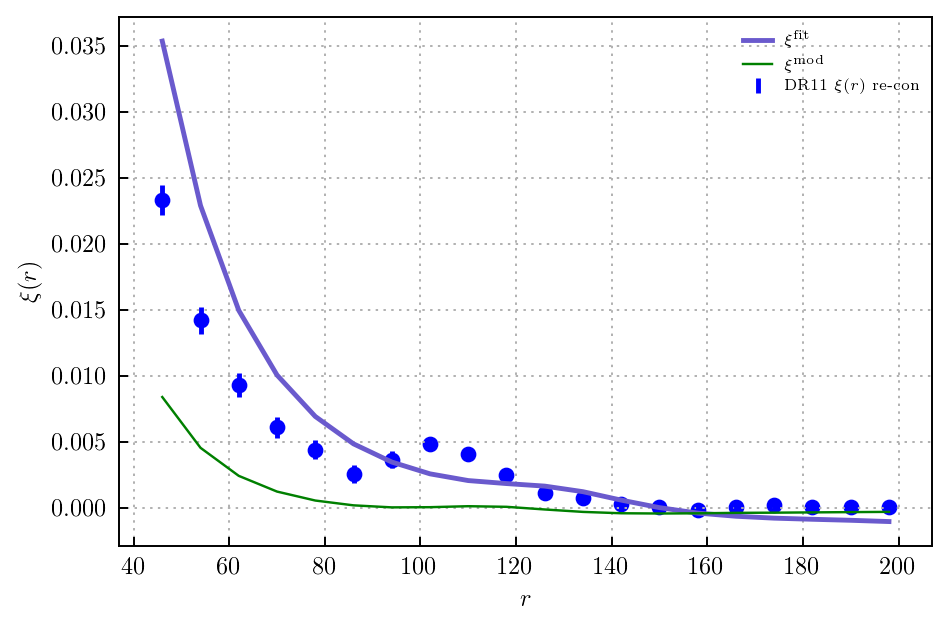

In [553]:
"""Plot results for fitting"""
# plot actual sigma(R) results
plt.xlabel(r'$r$'); plt.ylabel(r'$\xi (r)$')
plt.plot(r, xi_fit(theta_xi,r), c='slateblue', linewidth=2., label=r'$\xi ^{\rm fit}$')
plt.plot(r, xi_mod_spl(r), '-', c='g', linewidth=1., label=r'$\xi ^{\rm mod}$')
plt.errorbar(r, xi, yerr=exir2/r**2, linestyle="None" ,marker="None",ecolor='b',lw=2,capthick=2,label=r'DR11 $\xi(r)$ re-con')
plt.scatter(r, xi, c='b',s=30)
plt.legend(loc='upper right', frameon=False, fontsize=6)
plt.grid(ls='dotted')

plt.show()

### Plotting 2d histograms for rest of parameters

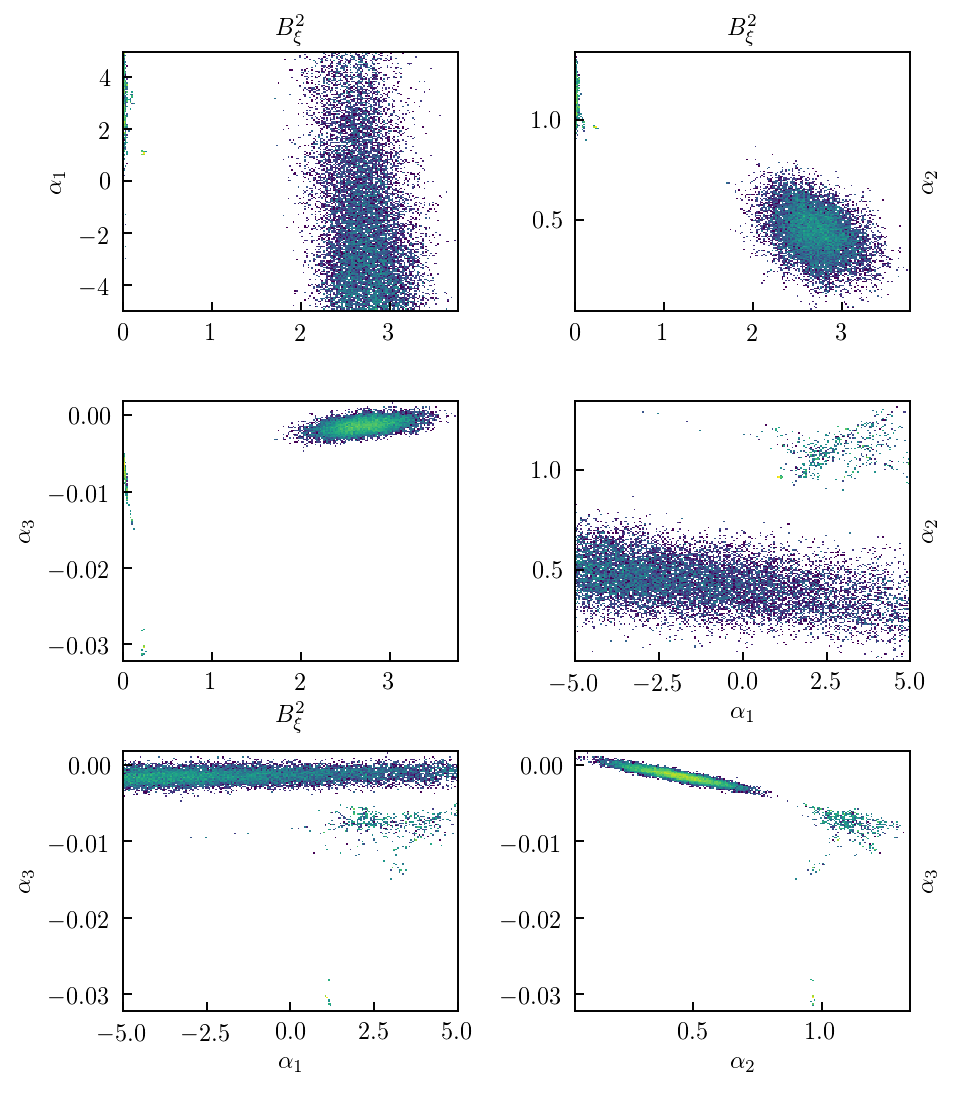

In [547]:
""" Plot parameters """
nbins=200; font_size = 10
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : font_size}
#--------------------------------------------
"""The plots"""
from matplotlib.colors import LogNorm
plt.figure(1)

# m vs c
sbplt1 = plt.subplot(321)
plt.hist2d(trace_xi[:,1], trace_xi[:,2], bins=nbins, norm=LogNorm())
plt.xlabel(r'$B_\xi^2$', fontsize=font_size)
plt.ylabel(r'$\alpha_1$', fontsize=font_size)
#sbplt1.set_title('', color='k', rotation='horizontal',x=0.5,y=1.05)
sbplt1.xaxis.set_label_position("top")

# m vs s
sbplt2 = plt.subplot(322)
plt.hist2d(trace_xi[:,1], trace_xi[:,3], bins=nbins, norm=LogNorm())
plt.xlabel(r'$B_\xi^2$', fontsize=font_size) 
plt.ylabel(r'$\alpha_2$', fontsize=font_size)
#sbplt2.set_title('m=%.3f, c=%.1e, s=$\pm$%.1e'%( np.mean(data_1p[:,0]), np.mean(data_1p[:,1]),\
#                            np.mean(data_1p[:,2][data_1p[:,2] > 0]) ), color='k', rotation='horizontal',x=0.5,y=1.05)
sbplt2.yaxis.set_label_position("right")
sbplt2.xaxis.set_label_position("top")

# m vs c
sbplt3 = plt.subplot(323)
plt.hist2d(trace_xi[:,1], trace_xi[:,4], bins=nbins, norm=LogNorm())
plt.xlabel(r'$B_\xi^2$', fontsize=font_size)
plt.ylabel(r'$\alpha_3$', fontsize=font_size)
#sbplt3.set_title('2 data points', color='k', rotation='horizontal',x=0.5,y=1.05)
#sbplt3.yaxis.set_label_position("right")

# m vs s
sbplt4 = plt.subplot(324)
plt.hist2d(trace_xi[:,2], trace_xi[:,3], bins=nbins, norm=LogNorm())
plt.xlabel(r'$\alpha_1$', fontsize=font_size) 
plt.ylabel(r'$\alpha_2$', fontsize=font_size)
#sbplt4.set_title('m=%.3f, c=%.1e, s=$\pm$%.1e'%( np.mean(data_2p[:,0]),\
#                    np.mean(data_2p[:,1]),\
#                    np.mean(data_2p[:,2][data_2p[:,2] > 0]) ), color='k', rotation='horizontal',x=0.5,y=1.05)
sbplt4.yaxis.set_label_position("right")

# m vs c
sbplt5 = plt.subplot(325)
plt.hist2d(trace_xi[:,2], trace_xi[:,4], bins=nbins, norm=LogNorm())
plt.xlabel(r'$\alpha_1$', fontsize=font_size)
plt.ylabel(r'$\alpha_3$', fontsize=font_size)
#sbplt5.set_title('All data points', color='k', rotation='horizontal',x=0.5,y=1.05)
#sbplt5.yaxis.set_label_position("right")

# m vs s
sbplt6 = plt.subplot(326)
plt.hist2d(trace_xi[:,3], trace_xi[:,4], bins=nbins, norm=LogNorm())
plt.xlabel(r'$\alpha_2$', fontsize=font_size)
plt.ylabel(r'$\alpha_3$', fontsize=font_size)
#sbplt6.set_title('m=%.3f, c=%.1e, s=$\pm$%.1e'%( np.mean(data_all[:,0]), np.mean(data_all[:,1]),\
#                 np.mean(data_all[:,2][data_all[:,2] > 0]) ),\
#                    color='k', rotation='horizontal',x=0.5,y=1.05)
sbplt6.yaxis.set_label_position("right")

plt.subplots_adjust(top=0.92, bottom=-0.45, left=0.10, right=0.85, hspace=0.35, wspace=0.35)

plt.rc('font', **font)

plt.show()

### Comments

* It is obvious that the fitting does not work properly. I tried various priors, but I could not make the model fit better than this to the data.

* The distribution for $\alpha$ sould be centered at $1$, but it seems that there are values near $0$ that are also sampled.

* $B_\xi^2$ seems to be somewhat well-confined, compared to the other parameters.

* After trying various combinations of parameters, $\alpha_3$ seems to be difficult to contrain, and also the sampling seems to be very sensitive to this parameter.

* Finally, I tried to make my GW10 sampler to work for this exercise, but failed to run it properly for many parameters.

## Part 2

In [46]:
"""Setup"""
# best-fit parameters from above
theta_best = np.array([np.mean(trace_xi[:,0]), np.mean(trace_xi[:,1]), np.mean(trace_xi[:,2]), \
                      np.mean(trace_xi[:,3]), np.mean(trace_xi[:,4])])

# Om0 array
Om0_array = np.linspace(0.1, 0.9, 50)
theta_omega = []

In [47]:
"""Power spectrum integration setup to derive xi^fit"""
def xi_int(lk, **kwargs):
    """Integrant for power spectrum computation""" 
    from scipy.special import spherical_jn
    k = 10.**lk; x = k * kwargs["R"];
    cosmo = kwargs["cosmo"]
    Pk = cosmo.matterPowerSpectrum(k, 'eh98')
    return  k**3 * Pk * np.exp(-(kwargs["Rc"]*k)**2) * spherical_jn(0,x)

def xi_r(r, rtol=1.e-6, **kwargs):
    """
    Computation of 2-point correlation function of matter in the universe
    Rc  = is the cutoff radius below which the integrand is suppressed exponentially;
            if zero, the integral is computed by splitting k into intervals corresponding to oscillations 
    """
    lkmin = kwargs["lkmin"]; lkmax = kwargs["lkmax"]    

    xi_r, err_r = romberg2(xi_int, lkmin, lkmax,  rtol=rtol, **kwargs)
    xi_r *= np.log(10.)/(2.*np.pi**2)
    err_r *= np.log(10.)/(2.*np.pi**2)
    return xi_r, err_r

def compute_xi_r(cosmo, r=r, fcut=1.e-3, rtol=1.e-8, lkmin=lkmin, lkmax=lkmax, mmax=40):

    xi_dummy = np.zeros_like(r); err_dummy = np.zeros_like(r)
    
    for i, rd in enumerate(r):
        rcutoff = fcut * rd
        lkmax = np.log10(2.0 * np.pi / rcutoff)

        kwargs = {"R":rd, "cosmo":cosmo, "Rc":rcutoff, "lkmin":lkmin, "lkmax":lkmax, "mmax":mmax}

        xi_dummy[i], err_dummy[i] = xi_r(rd, rtol=rtol, **kwargs) 

    return xi_dummy, err_dummy

In [48]:
def xi_fit(r, xi_mod=xi_mod_spl, theta_best=theta_best):
    """Fitting model definition"""
    alpha, Bxi2, alpha1, alpha2, alpha3 = theta_best
    Axi = alpha1/r**2 + alpha2/r + alpha3
    return Axi + Bxi2 * xi_mod(alpha*r)

def log_prior(theta):
    """ 
    Log of prior
    ============
    Flat priors for a1, a2, a3
    Gaussian prior for a, Bxi^2
    
    Input:
    ------
    theta  - vector of parameters (a, Bxi^2, a1, a2, a3)
    
    Output:
    -------
    Log of prior
    """
    Om, Ode = theta
    
    if  Om > 0. and Om < 1. and Ode > 0. and Ode < 1. - Om - 0.0001:
        # if inside allowed range 
        # note: I added a small number (0.0001) because I get errors otherwise
        return  np.log(200.** -len(theta))
    else: 
        # if outside allowed range
        return -np.inf # log(0)
    
def log_likelihood(theta, theta_best=theta_best, data=data, model=xi_fit):
    from numpy.linalg import inv
    """ 
    Logarithm of Likelihood function
    
    Inputs:
    -------
    theta  - vector of parameters (a, Bxi^2, a1, a2, a3)
    data   - the data we use
    model  - fitting model
    
    Output:
    -------
    ln of likelihood
    """
    r, xi = data
    # m-d and (m-d)^T
    md = model(r) - xi
    mdt = md.transpose()
    return -0.5 * md.dot(covij_inv).dot(mdt)

def log_posterior(theta, theta_best=theta_best, data=data, model=xi_fit):
    """ln of posterior"""
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

In [49]:
"""Iterations over cosmologies to find theta"""
for i in range(len(Om0_array)):
    """Cosmology setup for each Om0"""
    Om0 = Om0_array[i]; Ode0 = 1. - Om0 - 0.0001
    # define a vector of cosmological parameters:    
    my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': Om0, 'Ob0': 0.0001, 'sigma8': 0.8, 'ns': 0.95}
    # set my_cosmo to be the current cosmology	
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
    
    xi_mod = compute_xi_r(cosmo)[0]
    xi_spl = UnivariateSpline(r, xi_mod, s=0.)
    
    """Run emcee sampler"""
    # run MCMC sampler
    trace_omega = compute_mcmc(log_posterior, data=data, degree=1)

    # theta vector
    theta_omega.append([np.mean(trace_omega[:,0]),np.mean(trace_omega[:,1])])

Done Sampling in 3.256 s
Done Sampling in 3.235 s
Done Sampling in 3.244 s
Done Sampling in 3.245 s
Done Sampling in 3.254 s
Done Sampling in 3.243 s
Done Sampling in 3.249 s
Done Sampling in 3.248 s
Done Sampling in 3.237 s
Done Sampling in 3.245 s
Done Sampling in 3.251 s
Done Sampling in 3.231 s
Done Sampling in 3.248 s
Done Sampling in 3.234 s
Done Sampling in 3.252 s
Done Sampling in 3.242 s
Done Sampling in 3.266 s
Done Sampling in 3.236 s
Done Sampling in 3.252 s
Done Sampling in 3.258 s
Done Sampling in 3.467 s
Done Sampling in 3.268 s
Done Sampling in 3.255 s
Done Sampling in 3.246 s
Done Sampling in 3.235 s
Done Sampling in 3.266 s
Done Sampling in 3.698 s
Done Sampling in 3.247 s
Done Sampling in 3.245 s
Done Sampling in 3.252 s
Done Sampling in 3.258 s
Done Sampling in 3.277 s
Done Sampling in 3.327 s
Done Sampling in 3.252 s
Done Sampling in 3.252 s
Done Sampling in 3.252 s
Done Sampling in 3.249 s
Done Sampling in 3.226 s
Done Sampling in 3.256 s
Done Sampling in 3.310 s


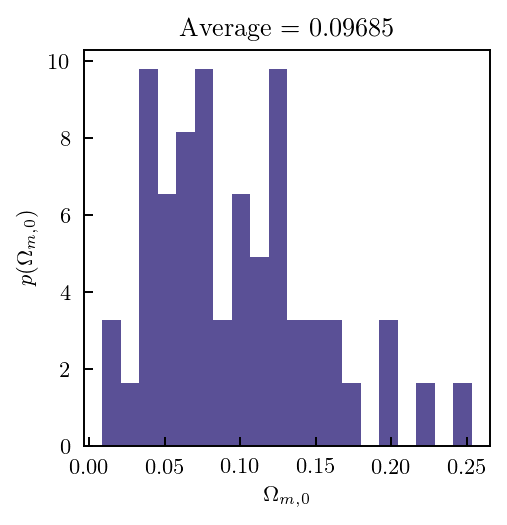

68.00 per cent confidence interval for Om0 using all point(s) = [0.04446 , 0.11925]
95.00 per cent confidence interval for Om0 using all point(s) = [0.01492 , 0.19747]


In [56]:
#
# histogram for Om0, and confidence intervals
#
marg_posterior(np.array(theta_omega)[:,0], nbins=20, xlabel=r'$\Omega_{m,0}$', ylabel=r'$p(\Omega_{m,0})$', \
               title='Average = %.5f'%(np.mean(np.array(theta_omega)[:,0])))
conf_level(np.array(theta_omega)[:,0], confidence=68., theta='Om0', Np='all')
conf_level(np.array(theta_omega)[:,0], confidence=95., theta='Om0', Np='all')

### Comments

* As in the previous part, this part does not work properly for me.

* First of all, the theta I used a the "best-fit" ones are obviously not correct.

* Also, there seems to be a problems with the method I sample the parameter space in this exercise in general. I could not figure out what the problem is.

* If I were to guess, I probably do not use suitable priors. I tried to use many different ones, and also change the way I write them (this seems to play an important role for some reason), but every time the results were not correct.